**E9 333 Advanced Deep Representation Learning (2022)**

---


Assignment 02

---


Submission by: Dhruv Bhardwaj (SR 19280), Bhartendu Kumar (SR 19649), MTech AI

# Diffusion Models

## Standard Imports

In [ ]:
import torch
torch.manual_seed(42)

from torch.nn import Conv2d, ConvTranspose2d, Linear, Embedding
from torch.nn import MaxPool2d, BatchNorm2d
from torch.nn import LeakyReLU, Tanh, ReLU, Sigmoid
from torch.nn import Module
from torch.nn import MSELoss
from torch import flatten
import numpy
import random
import os, os.path
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image

#########################################################3
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)
#########################################################3

## Configurations for different tasks

### CelebA Dataset

In [ ]:
cfg={       
        'diffusion':{
            'T':500,
            'guided':True,
            'guiding_classifier':'adrl/e0_333_adrl/Assignment_02/chkpt/classifier/classifier20_expt_1a_classifier.chk.pt'            
        },
        'training':{
            'batch_size':128,
            'num_epochs':15,
            'lr':0.001,
            'save_path':'./logs/',
            'data_path':'adrl/datasets/img_align_celeba_resampled/',
            'file_extn':'jpg',
            'chkpt_path':'./chkpt/celeba/',
            'chkpt_file':'expt_1a_celeba.chk.pt',
            'load_from_chkpt':False
        },
        'ddpm':{
            'image_size':64,
            'channels':3            
        },
        'classifier':{
            'num_classes':10,
            'batch_size':64,
            'num_epochs':20,
            'lr':0.0001,
            'save_path':'./logs/',
            'data_path':'adrl/datasets/img_align_celeba_classes/',
            'file_extn':'jpg',
            'chkpt_path':'./chkpt/',
            'chkpt_file':'expt_1a_classifier.chk.pt',
            'load_from_chkpt':False
        }
    }

### bitmoji Dataset

In [ ]:
cfg={        
        'diffusion':{
            'T':500            
        },
        'training':{
            'batch_size':8,
            'num_epochs':5,
            'lr':0.001,
            'save_path':'./logs/',
            'data_path':'adrl/datasets/bitmojis_resampled/',
            'file_extn':'png',
            'chkpt_path':'./chkpt/',
            #'chkpt_file':'expt_1a_bitmojis.chk.pt',
            'chkpt_file':'expt_2_bitmojis.chk.pt',
            'load_from_chkpt':False
        },
        'ddpm':{
            'image_size':64,
            'channels':3
        },
        'ebm':{
            'sample_eps': 10,
            'num_steps':100
        }
    }

## DataLoader Class and Utilities Definitions

In [ ]:
class ImageDataset(Dataset):
    def __init__(self,img_folder, extn='.jpg'):
        self.img_folder=img_folder   
        self.extn = extn
        self.img_list = [name for name in os.listdir(self.img_folder) if name.endswith(self.extn)]
        #print(self.img_list[9])
        return
    
    def __len__(self):
        return len(self.img_list)
    
    def __getitem__(self,index):     
        #print(self.img_list[index])
        image=read_image(self.img_folder+'/'+self.img_list[index])    
        #print(image.size())   
        #image = image[0,:,:].unsqueeze(0)   
        image=image/255.0        
        image=image.float()                
        image = -1.0 + 2.0*image
        return image

def getDataloader(data_path, batch_size, extn):
    print('[INFO] DATA_PATH={}, BATCH_SIZE={}'.format(data_path,batch_size))
    imgDataset = ImageDataset(data_path,extn)    
    print('[INFO] Found data set with {} samples'.format(len(imgDataset)))
    dl = DataLoader(imgDataset, batch_size,
                    shuffle=True)
    return dl, len(imgDataset)

In [ ]:
class Logger(object):
    def __init__(self, dir1='logs', filename="Default.log"):
        self.terminal = sys.stdout
        if not os.path.exists(dir1):
            os.makedirs(dir1)
        self.log = open(os.path.join(dir1,filename), "a")

    def write(self, message):
        self.terminal.write(message)
        self.log.write(message)
    
    def flush(self):
        pass



def create_resampled_images(in_path,out_path,extn):
    transform = T.Resize((64,64))

    dl,_ = DS.getDataloader(in_path,32,extn)
    k=0
    for image_batch in dl:
        print(image_batch.size())
        for i in range(0,image_batch.size(0)):
            save_image(transform(image_batch[i]),out_path + '/' + str(k) + extn) 
            k +=1

    print(k)
    return

def save_image_to_file(epoch,image_tensor, save_path,ref_str=None):
    print(image_tensor.size())
    if ref_str is not None:
        filestr = save_path + ref_str +'SAMPLE_IMGS_E'+ str(epoch)  + '.jpg'
    else:
        filestr = save_path + 'SAMPLE_IMGS_E'+ str(epoch)  + '.jpg'
    save_image(image_tensor,filestr,nrow = 10) 
    return

def save_one_image_per_file(epoch,image_tensor, save_path,ref_str=None):
    print(image_tensor.size())
    
    k=0
    for i in range(image_tensor.size(0)):
        if ref_str is not None:
            filestr = save_path + ref_str+ str(k) +'_SAMPLE_IMG_E'+ str(epoch)  + '.png'
        else:
            filestr = save_path + str(k)+'_SAMPLE_IMG_E'+ str(epoch)  + '.png'
        save_image(image_tensor[i].squeeze(0),filestr) 
        k+=1
    return


def return_random_batch_from_dir(img_folder, file_extn, num_samples):
    img_list = [name for name in os.listdir(img_folder) if name.endswith(file_extn)]
    samples=[]
    if(len(img_list)>0):
        
        sample_names = random.sample(img_list, num_samples)
        for name in sample_names:
            img = read_image(img_folder+'/'+name).float()
            img = img/255.0
            samples.append((img.unsqueeze(0)))
        samples = torch.cat(samples)
        print(samples.size())
    return samples

## Model definitions

### Unet Model for diffusion
(refer: https://github.com/lucidrains/denoising-diffusion-pytorch)

In [ ]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):        
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,        
        convnext_mult=2,
        encoder_only=False
    ):
        super().__init__()
        self.encoder_only=encoder_only
        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
                
        block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        
        if self.encoder_only is False:
            print('decoder')
            for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
                is_last = ind >= (num_resolutions - 1)

                self.ups.append(
                    nn.ModuleList(
                        [
                            block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                            block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                            Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                            Upsample(dim_in) if not is_last else nn.Identity(),
                        ]
                    )
                )

            out_dim = default(out_dim, channels)
            self.final_conv = nn.Sequential(
                block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
            )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        if self.encoder_only is False:            
            for block1, block2, attn, upsample in self.ups:
                x = torch.cat((x, h.pop()), dim=1)
                x = block1(x, t)
                x = block2(x, t)
                x = attn(x)
                x = upsample(x)
            
            x = self.final_conv(x)

        return x


### Diffusion Model Class definition

In [ ]:
def getSchedule(betas):
        schedule={}
        schedule['alphas'] = 1. - betas
        schedule['alphas_cumprod'] = torch.cumprod(schedule['alphas'], axis=0)
        schedule['alphas_cumprod_prev'] = F.pad(schedule['alphas_cumprod'][:-1], (1, 0), value=1.0)
        schedule['sqrt_recip_alphas'] = torch.sqrt(1.0 / schedule['alphas'])
        schedule['sqrt_alphas_cumprod'] = torch.sqrt(schedule['alphas_cumprod'])
        schedule['sqrt_one_minus_alphas_cumprod'] = torch.sqrt(1. - schedule['alphas_cumprod'])
        schedule['posterior_variance'] = betas * (1. - schedule['alphas_cumprod_prev']) / (1. - schedule['alphas_cumprod'])
        return schedule

class DiffusionNet(nn.Module):
    def __init__(self,cfg, device):
        super(DiffusionNet,self).__init__()

        self.cfg = cfg['diffusion']        
        self.betas = linear_beta_schedule(timesteps=self.cfg['T'])
        self.device = device
        self.schedule=getSchedule(self.betas)
        

        self.net=Unet(dim=cfg['ddpm']['image_size'], channels=cfg['ddpm']['channels'],dim_mults=(1, 2, 4,))

        print(self.net)        
            
                
    def q_sample(self,x_start, noise=None):
        b,c,h,w = x_start.size()
        
        sqrt_alphas_cumprod_t = extract(self.schedule['sqrt_alphas_cumprod'], self.t, x_start.size()).to(self.device)
        sqrt_one_minus_alphas_cumprod_t = extract(
            self.schedule['sqrt_one_minus_alphas_cumprod'], self.t, x_start.size()
        ).to(self.device)

        e0 = torch.randn_like(x_start).float().to(self.device)
        
        e = torch.mul(sqrt_one_minus_alphas_cumprod_t,e0)
        e = e + torch.mul(sqrt_alphas_cumprod_t,x_start)

        e = torch.reshape(e.permute(1,0),(b,c,h,w)).float()

        return e, e0

    @torch.no_grad()
    def p_sample(self,x, t, t_index, classifier=None):
        betas_t = extract(self.betas, t, x.shape).to(self.device)
        sqrt_one_minus_alphas_cumprod_t = extract(
            self.schedule['sqrt_one_minus_alphas_cumprod'], t, x.shape
        ).to(self.device)
        sqrt_recip_alphas_t = extract(self.schedule['sqrt_recip_alphas'], t, x.shape).to(self.device)

        if(classifier is not None):
            classifier.eval()
            classifier_score = sqrt_one_minus_alphas_cumprod_t*10*classifier.score_fn(x,t)
            model_mean = sqrt_recip_alphas_t * (
            x - betas_t * (self.net(x, t)-classifier_score.to(self.device)) / sqrt_one_minus_alphas_cumprod_t
            )
        else:
            model_mean = sqrt_recip_alphas_t * (
            x - betas_t * self.net(x, t) / sqrt_one_minus_alphas_cumprod_t
            )
        

        if t_index == 0:
            return model_mean
        else:
            posterior_variance_t = extract(self.schedule['posterior_variance'], t, x.shape).to(self.device)
            noise = torch.randn_like(x)

            return model_mean + torch.sqrt(posterior_variance_t) * noise 


    @torch.no_grad()
    def p_sample_loop(self, classifier, shape):

        b = shape[0]
        # start from pure noise (for each example in the batch)
        img = torch.randn(shape, device=self.device)
        imgs = []

        for i in tqdm(reversed(range(0, self.cfg['T'])), desc='sampling loop time step', total=self.cfg['T']):
            img = self.p_sample(img, torch.full((b,), i, device=self.device, dtype=torch.long), i, classifier)
            imgs.append(img.cpu())
        return imgs

    @torch.no_grad()
    def sample(self, image_size, batch_size=16, channels=3, classifier=None):
        return self.p_sample_loop(classifier, shape=(batch_size, channels, image_size, image_size))

        
    def forward(self,x):
        self.t = torch.randint(low=0,high=self.cfg['T']-1,size=(x.size(0),),device=self.device).long()
        
        e,e0 = self.q_sample(x)
        #print(e.size(),e0.size())
        e = self.net(e, self.t)  
        #print(e.size())      
        return e, e0

    def criterion(self,e,e0):
           
        loss = F.mse_loss(e,e0, reduction='sum')
        return loss

### Classifier for guided Diffusion

In [ ]:
class DiffusionClassifier(nn.Module):
    def __init__(self,cfg,num_classes, device):
        super(DiffusionClassifier,self).__init__()
        self.cfg=cfg
        self.betas = linear_beta_schedule(timesteps=self.cfg['diffusion']['T'])        
        self.schedule=getSchedule(self.betas)

        self.num_classes = num_classes
        self.net=Unet(dim=cfg['ddpm']['image_size'], channels=cfg['ddpm']['channels'],dim_mults=(1, 2, 4,),encoder_only=True)
        
        self.dense1 = nn.Linear(256*16*16,1024)
        self.dense2 = nn.Linear(1024,self.num_classes)

        self.device = device
        print(self.net)

    def forward(self,x, t):
        self.t = t
        e,_ = self.q_sample(x)
        x = self.net(e,self.t)
        x = torch.flatten(x,start_dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        return x
    
    def score_fn(self,x,t):
        with torch.enable_grad():            
            x_in = x.detach().requires_grad_(True)
            x_in = transform(x_in)
            out = self.forward(x_in, t)
            log_probs = F.log_softmax(out, dim=1)            
            selected = torch.diagonal(log_probs)
            
            score = torch.autograd.grad(selected.sum(), x_in)
            
            return score[0]

    def q_sample(self,x_start, noise=None):
        b,c,h,w = x_start.size()
        
        sqrt_alphas_cumprod_t = extract(self.schedule['sqrt_alphas_cumprod'], self.t, x_start.size()).to(self.device)
        sqrt_one_minus_alphas_cumprod_t = extract(
            self.schedule['sqrt_one_minus_alphas_cumprod'], self.t, x_start.size()
        ).to(self.device)

        e0 = torch.randn_like(x_start).float().to(self.device)
        
        e = torch.mul(sqrt_one_minus_alphas_cumprod_t,e0)
        e = e + torch.mul(sqrt_alphas_cumprod_t,x_start)

        e = torch.reshape(e.permute(1,0),(b,c,h,w)).float()

        return e, e0

### Energy based model

In [ ]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)

class EBM(nn.Module):
    def __init__(self,cfg, device):
        super(EBM,self).__init__()
        self.cfg=cfg        
        self.alpha = cfg['ebm']['alpha']
        self.step_size = cfg['ebm']['step_size']
        self.T = cfg['ebm']['num_steps']     
        self.img_shape = cfg['ebm']['buffer_shape']
        self.buffer_len=cfg['ebm']['buffer_len']
        self.buffer=[torch.rand(self.img_shape)*2.0-1 for _ in range(self.buffer_len)]          
        
        layers=[]
        layers.append(nn.Conv2d(cfg['ddpm']['channels'],32,kernel_size=3,bias=False))
        layers.append(Swish())
        layers.append(nn.Conv2d(32,64,kernel_size=3,bias=False))
        layers.append(Swish())
        layers.append(nn.AvgPool2d(kernel_size=2,stride=2))
        layers.append(nn.Conv2d(64,64,kernel_size=3,bias=False))
        layers.append(Swish())
        layers.append(nn.Conv2d(64,128,kernel_size=3,bias=False))
        layers.append(Swish())
        layers.append(nn.AvgPool2d(kernel_size=2,stride=2))
        layers.append(nn.Conv2d(128,128,kernel_size=3,bias=False))
        layers.append(Swish())
        layers.append(nn.Conv2d(128,256,kernel_size=3,bias=False))
        layers.append(Swish())
        layers.append(nn.AvgPool2d(kernel_size=2,stride=2))
        layers.append(nn.Conv2d(256,512,kernel_size=4,bias=False))        

        self.conv = nn.Sequential(*layers)
        
        self.dense1 = nn.Linear(512,1)

        self.device = device
        print(self)
        print(len(self.buffer))
        # for i in range(self.buffer_len):
        #     print(self.buffer[i].size())

    def forward(self,x):
                
        x = self.conv(x)        
        x = torch.flatten(x,start_dim=1)        
        return self.dense1(x)

    def criterion(self, es, e):        
        return torch.mean((e - es) + self.alpha*(es**2 + e**2))

    def sample(self,x_shape):
        
        n_new = np.random.binomial(x_shape[0], 0.05)
        if(n_new==0):
            n_new=1
        # print(n_new,x_shape)
        ll = random.choices(self.buffer, k=x_shape[0]-n_new)
        for i in range(len(ll)):
            ll[i]=ll[i].squeeze(0)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1        
        old_imgs = torch.stack(ll, dim=0)
        x = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(self.device)    
        x.requires_grad=True
        
        for _ in range(0,self.T):            
            noise =  0.005*torch.randn_like(x, device=self.device)    
            energy = self.forward(x)            
            grad = torch.autograd.grad(energy.sum(),x)[0]    
            grad.clamp(-0.05,0.05)        
            x = x - self.step_size*grad + noise 
            x.clamp(-1.,1.)             

        self.buffer = list(x.to(torch.device("cpu")).chunk(x_shape[0], dim=0)) + self.buffer
        self.buffer = self.buffer[:self.buffer_len]

        return x.detach()
    
    def sample_from_buffer(self,x_shape):
        assert self.buffer_len >= x_shape[0]
       
        n_new=1
        # print(n_new,x_shape)
        ll = random.choices(self.buffer, k=x_shape[0]-n_new)
        for i in range(len(ll)):
            ll[i]=ll[i].squeeze(0)
        rand_imgs = torch.rand((n_new,) + self.img_shape) * 2 - 1        
        old_imgs = torch.stack(ll, dim=0)
        x = torch.cat([rand_imgs, old_imgs], dim=0).detach().to(self.device)    
        x.requires_grad=True
        
        for _ in range(0,self.T):            
            noise =  0.005*torch.randn_like(x, device=self.device)    
            energy = self.forward(x)            
            grad = torch.autograd.grad(energy.sum(),x)[0]            
            grad.clamp(-0.05,0.05)
            x = x - self.step_size*grad + noise    
            x.clamp(-1.,1.)

        return x.detach()

## Unguided Diffusion (CelebA/bitmoji)

In [ ]:
#from config_1a_celeba import cfg
from config_1a_bitmojis import cfg
from datasets import getDataloader
import utils as util
#from models import DiffusionNet
from ddpm_models import DiffusionNet
#########################LOGGER#########################
sys.stdout = util.Logger(cfg['training']['save_path'],'expt_1a_bitmojis.txt')
#########################################################3

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
print(device)
#########################################################3
train_cfg = cfg['training']
def train():
    print('-' * 59)
    torch.cuda.empty_cache()
    model = DiffusionNet(cfg, device)

    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=train_cfg['lr'])
    
    if(train_cfg['load_from_chkpt']):        
        chkpt_file = os.path.join(train_cfg['chkpt_path'],train_cfg['chkpt_file'])
        print('Loading checkpoint from:',chkpt_file)
        checkpoint = torch.load(chkpt_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_start=1+checkpoint['epoch']        
    else:
        epoch_start=1            
    
    model.train()
    
    data, N = getDataloader(train_cfg['data_path'],train_cfg['batch_size'], train_cfg['file_extn'])
    
    print('-' * 59)
    print("Starting Training of model")
    epoch_times = []

    for epoch in range(epoch_start,train_cfg['num_epochs']+1):        
        start_time = time.process_time()        
        total_loss = 0.0
        
        counter = 0
        for image_batch in data:
            
            counter += 1            
            optimizer.zero_grad()           

            e_hat, e = model(image_batch.to(device)) 
                    
            loss = model.criterion(e_hat, e)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()            
            
            if counter%500 == 0:                
                print("Epoch {}......Step: {}/{}....... Loss={:12.5}"
                .format(epoch, counter, len(data), total_loss/train_cfg['batch_size']))
        
        current_time = time.process_time()
        print(N)
        print("Epoch {}/{} Done, Loss = {:12.5}"
                .format(epoch, train_cfg['num_epochs'], total_loss/N))

        print("Total Time Elapsed={:12.5} seconds".format(str(current_time-start_time)))        
        
        if(epoch%5==0):
            x = model.sample(cfg['ddpm']['image_size'],100,cfg['ddpm']['channels'])
            torch.save({
                'epoch': epoch,
                'loss':total_loss,                
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),                 
                }, os.path.join(train_cfg['chkpt_path'],'e' + str(epoch) + '_' + train_cfg['chkpt_file']))            
            
            
            util.save_image_to_file(epoch,0.5*(x[0]+1),train_cfg['save_path'],'TT_')
            util.save_image_to_file(epoch,0.5*(x[-1]+1),train_cfg['save_path'],'T0_')
            model.train()

        epoch_times.append(current_time-start_time)
        print('-' * 59)

    print("Total Training Time={:12.5} seconds".format(str(sum(epoch_times))))
    return model

def sample_images_from_model(cfg,chkpt_file,num_samples, t_list=None):

    model = DiffusionNet(cfg, device)
    model.to(device)

    train_cfg=cfg['training']
    
    print('Loading checkpoint from:',chkpt_file)
    checkpoint = torch.load(chkpt_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model.eval()
    x = model.sample(cfg['ddpm']['image_size'],num_samples,cfg['ddpm']['channels'])
    print(len(x))
    print(x[0].size())
    timed_samples=[]
    if(t_list is not None):        
        for t in t_list:
            timed_samples.append(x[t])
        print(len(timed_samples))
        print(timed_samples[0].size())
    return x, timed_samples


In [ ]:
print(cfg)
model = train()
chkpt_file = 'adrl/e0_333_adrl/Assignment_02/chkpt/bitmoji/e15_expt_1a_bitmojis.chk.pt'
x,_ = sample_images_from_model(cfg,chkpt_file,500,None)    
util.save_one_image_per_file(500,0.5*(x[-1]+1),'adrl/e0_333_adrl/Assignment_02/chkpt/images/bitmoji_diff_output/',None)

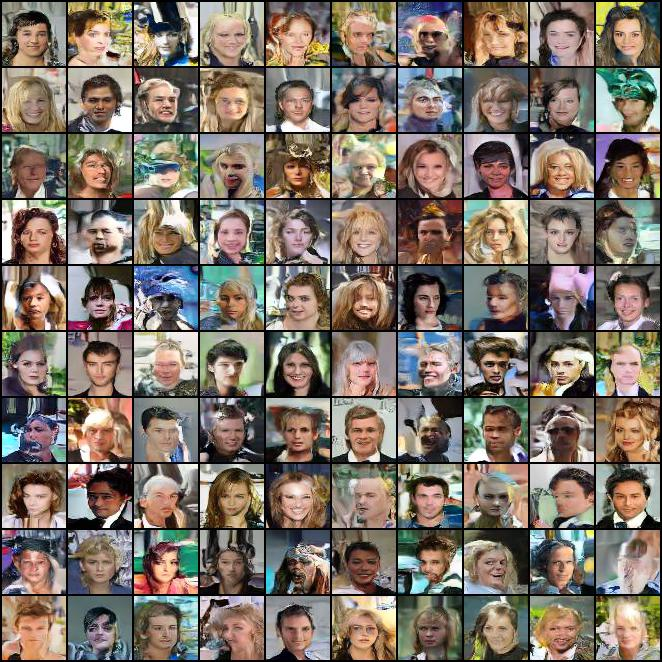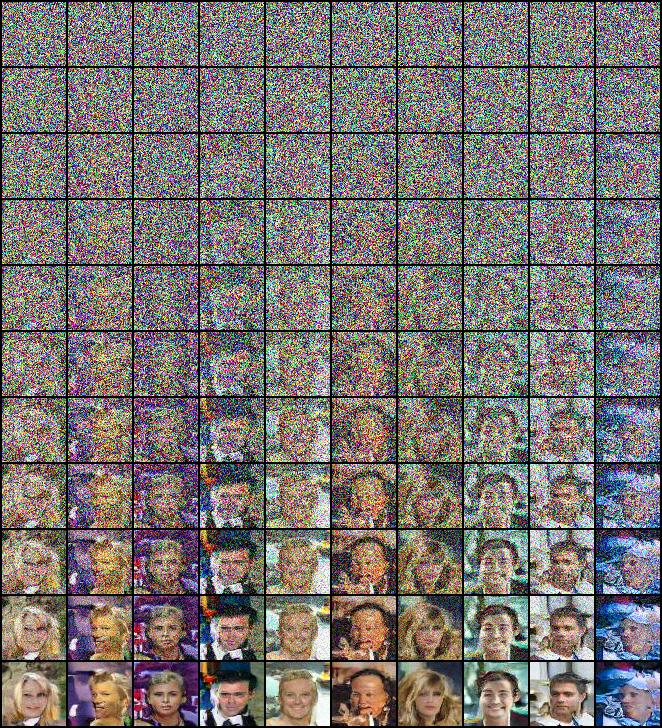

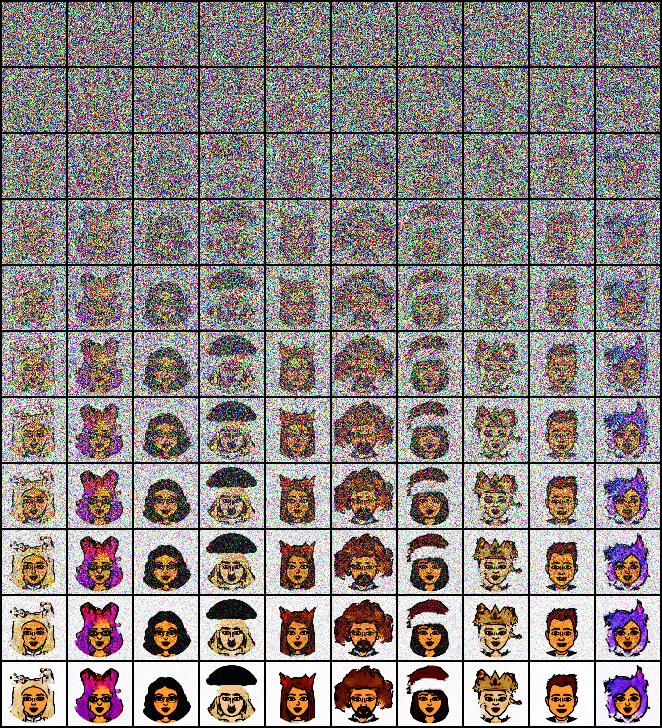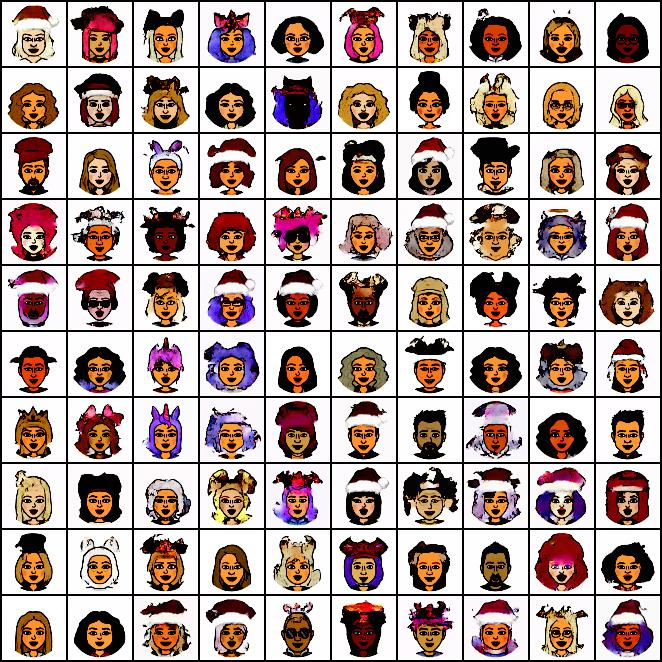

## Classifier guided diffusion

In [ ]:
import torch
import numpy as np
import time
import datetime
import sys
import random
import os

from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

from config_1a_celeba import cfg
import utils as util

from ddpm_models import DiffusionNet, DiffusionClassifier

sys.stdout = util.Logger(cfg['training']['save_path'],'expt_1a_celeba_classifier.txt')
#########################################################3

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)
#########################################################3
classifier_cfg = cfg['classifier']

#########################################################3
def validate(model, valid_loader, criterion):
    model.eval()
    total_loss = 0.0
    for data in valid_loader:
        image_batch, label = data                  
        t = torch.randint(low=0,high=cfg['diffusion']['T']-1,size=(image_batch.size(0),),device=device).long()
        label_hat = model(image_batch.to(device),t) 
                    
        loss = criterion(label_hat, label.to(device))        
            
        total_loss += loss.item() 
    
    model.train()
    return total_loss

def train():
    print('-' * 59)
    torch.cuda.empty_cache()
    model = DiffusionClassifier(cfg, classifier_cfg['num_classes'],device)

    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=classifier_cfg['lr'])
    criterion = torch.nn.CrossEntropyLoss()
    if(classifier_cfg['load_from_chkpt']):        
        chkpt_file = os.path.join(classifier_cfg['chkpt_path'],classifier_cfg['chkpt_file'])
        print('Loading checkpoint from:',chkpt_file)
        checkpoint = torch.load(chkpt_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_start=1+checkpoint['epoch']        
    else:
        epoch_start=1            
    
    model.train()
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0., 0., 0.], std=[1., 1., 1.])
        ])

    train_dataset = ImageFolder(root=os.path.join(classifier_cfg['data_path'],'train'),transform=transform)
    val_dataset = ImageFolder(root=os.path.join(classifier_cfg['data_path'],'val'),transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=classifier_cfg['batch_size'],shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=classifier_cfg['batch_size'],shuffle=False)

    print('-' * 59)
    print("Starting Training of model")
    epoch_times = []

    for epoch in range(epoch_start,classifier_cfg['num_epochs']+1):        
        start_time = time.process_time()        
        total_loss = 0.0
        
        counter = 0
        for data in train_loader:
            image_batch, label = data            

            counter += 1            
            optimizer.zero_grad()           
            t = torch.randint(low=0,high=cfg['diffusion']['T']-1,size=(image_batch.size(0),),device=device).long()

            label_hat = model(image_batch.to(device),t) 
                    
            loss = criterion(label_hat, label.to(device))
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()            
            
            if counter%500 == 0:                
                print("Epoch {}......Step: {}....... Loss={:12.5}"
                .format(epoch, counter, total_loss))
        
        current_time = time.process_time()        
        print("Epoch {}/{} Done, Loss = {:12.5}"
                .format(epoch, classifier_cfg['num_epochs'], total_loss))
        val_loss = validate(model, valid_loader, criterion)
        print("Epoch {}/{} Done, Val Loss = {:12.5}"
                .format(epoch, classifier_cfg['num_epochs'], val_loss))

        print("Total Time Elapsed={:12.5} seconds".format(str(current_time-start_time)))        
        
        if(epoch%5==0):            
            torch.save({
                'epoch': epoch,
                'loss':total_loss,                
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),                 
                }, os.path.join(classifier_cfg['chkpt_path'],'classifier' + str(epoch) + '_' + classifier_cfg['chkpt_file']))            

        epoch_times.append(current_time-start_time)
        print('-' * 59)

    print("Total Training Time={:12.5} seconds".format(str(sum(epoch_times))))
    return model
    

In [ ]:
print(cfg)
    #model = train()

    chkpt_file = 'adrl/e0_333_adrl/Assignment_02/chkpt/celeba/e15_expt_1a_celeba.chk.pt'
    model = DiffusionNet(cfg, device)
    model.to(device)    
    
    print('Loading diffusion checkpoint from:',chkpt_file)
    checkpoint = torch.load(chkpt_file)
    model.load_state_dict(checkpoint['model_state_dict'])    
    model.eval()

    if(cfg['diffusion']['guided']):                    
        classifier = DiffusionClassifier(cfg, cfg['classifier']['num_classes'],device)
        print('Loading classifier from:',cfg['diffusion']['guiding_classifier'])
        checkpoint = torch.load(cfg['diffusion']['guiding_classifier'])
        classifier.load_state_dict(checkpoint['model_state_dict'])
        classifier.to(device)
        classifier.eval()

    x=[]
    for i in range(10):
        x0 = model.sample(cfg['ddpm']['image_size'],cfg['classifier']['num_classes'],cfg['ddpm']['channels'], classifier)             
        x.append(x0[-1])
    
    x=torch.cat(x)
    print(x.size())
    util.save_image_to_file(0,0.5*(x+1),cfg['training']['save_path'],'Conditional_T0_')

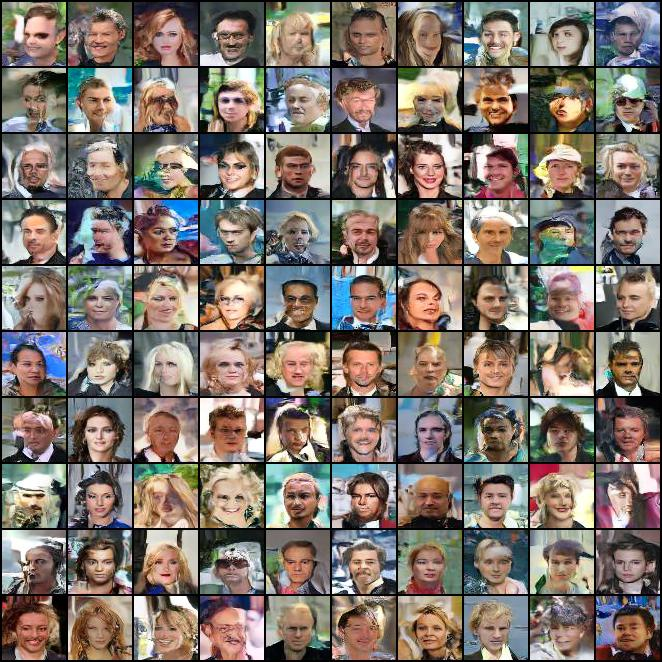

## Energy based models

In [ ]:
from config_1a_bitmojis import cfg
from datasets import getDataloader
import utils as util

from ddpm_models import EBM

#########################################################3
#cfg = config.cfg
#########################LOGGER#########################
sys.stdout = util.Logger(cfg['training']['save_path'],'expt_2_bitmojis.txt')
#########################################################3
#torch.autograd.set_detect_anomaly(True)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')
print(device)
#########################################################3
train_cfg = cfg['training']
def train():
    print('-' * 59)    
    model = EBM(cfg, device)

    model.to(device)
        
    optimizer = torch.optim.Adam(model.parameters(), lr=train_cfg['lr'])
    
    epoch_start=1            
    
    model.train()
    
    data, N = getDataloader(train_cfg['data_path'],train_cfg['batch_size'], train_cfg['file_extn'])
    
    print('-' * 59)
    print("Starting Training of model")
    epoch_times = []

    for epoch in range(epoch_start,train_cfg['num_epochs']+1):        
        start_time = time.process_time()        
        total_loss = 0.0
        
        counter = 0
        for image_batch in data:
            
            counter += 1            
            image_batch_samples = model.sample(image_batch.size())                       
            
            optimizer.zero_grad()                                  
            
            es = model(image_batch_samples.to(device))                                                     
            e = model(image_batch.to(device)) 

            loss = model.criterion(es.detach(), e)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            
            optimizer.step()
            
            total_loss += loss.item()            
            
            if counter%500 == 0:                
                print("Epoch {}......Step: {}/{}....... Loss={:12.5}"
                .format(epoch, counter, len(data), total_loss/train_cfg['batch_size']))                                
            
            if counter%1000 == 0:                
                break
                
        
        current_time = time.process_time()
        print(N)
        print("Epoch {}/{} Done, Loss = {:12.5}"
                .format(epoch, train_cfg['num_epochs'], total_loss/N))

        print("Total Time Elapsed={:12.5} seconds".format(str(current_time-start_time)))        
        
        if(epoch%1==0):
            model.eval()
            x = model.sample_from_buffer((100,3,64,64))
            print(x.size())
            # torch.save({
            #     'epoch': epoch,
            #     'loss':total_loss,                
            #     'model_state_dict': model.state_dict(),
            #     'optimizer_state_dict': optimizer.state_dict(),                 
            #     }, os.path.join(train_cfg['chkpt_path'],'e' + str(epoch) + '_' + train_cfg['chkpt_file']))            
            util.save_image_to_file(epoch,0.5*(x+1),train_cfg['save_path'],str(cfg['ebm']['num_steps'])+'EBM_')
            model.train()

        epoch_times.append(current_time-start_time)
        print('-' * 59)

    print("Total Training Time={:12.5} seconds".format(str(sum(epoch_times))))
    return model

def sample_images_from_model(cfg,chkpt_file,num_samples, t_list=None):

    model = DiffusionNet(cfg, device)
    model.to(device)

    train_cfg=cfg['training']
    
    print('Loading checkpoint from:',chkpt_file)
    checkpoint = torch.load(chkpt_file)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model.eval()
    x = model.sample(cfg['ddpm']['image_size'],num_samples,cfg['ddpm']['channels'])
    print(len(x))
    print(x[0].size())
    timed_samples=[]
    if(t_list is not None):        
        for t in t_list:
            timed_samples.append(x[t])
    print(len(timed_samples))
    print(timed_samples[0].size())
    return x, timed_samples




In [ ]:
    print(cfg)
    model = train()

# Domain Adaptation

## refractor Office Home Dataset

In [ ]:
#in this script we will refactor the dataset for clsssiication tasks
# we have 65 classes and the class labels are strings, so we will convert them to integers
#the dataset is at the location: officehome
#the structure of the dataset is as follows:
#officehome
#   |---Clipart
#          |---Alarm_Clock
#          |---Backpack
#..... like this 65 folders in total in Clipart
#then
#   |---Real_World
#          |---Alarm_Clock
#          |---Backpack
#..... like this 65 folders in total in Real_World
#we have only 2 folders : Clipart and Real_World
#our task is to rename the folders in Clipart and Real_World to integers from 0 to 64
#dataset location is : data/officehome
data_path = 'data/officehome/'

#let us import necessary libraries
import os
import numpy as np
import pandas as pd
from shutil import copyfile
from os import listdir
from os.path import isfile, join
#import re
import shutil
import glob
import pickle
#first we will create a list of all the folders in Clipart and Real_World
list_of_folders = [f for f in listdir(data_path+'Clipart') if not isfile(join(data_path+'Clipart', f))]
#sort the list
list_of_folders.sort()
#now we have a sorted list of all the folders in Clipart
#print(list_of_folders)
print(len(list_of_folders))
print(list_of_folders)

#get the list of folders from Real_World and check if both are same
pseudo_list_of_folders = [f for f in listdir(data_path+'Real_World') if not isfile(join(data_path+'Real_World', f))]
#sort
pseudo_list_of_folders.sort()
#check if both are same
if(list_of_folders==pseudo_list_of_folders):
    print('both are same')
#now we save the list of folders in a pickle file
#so that we can use it later

with open(data_path+'list_of_folders.pkl', 'wb') as f:
    pickle.dump(list_of_folders, f)
#num_classes as len(list_of_folders)
NUM_CLASSES = len(list_of_folders)
NUM_CLASSES
#now we create a dictionary with key as the folder name and value as the integer
dict_of_folders = {}
for i in range(NUM_CLASSES):
    dict_of_folders[list_of_folders[i]] = i
print(dict_of_folders)
#save dict_of_folders in a pickle file
#so that we can use it later
with open(data_path+'dict_of_folders.pkl', 'wb') as f:
    pickle.dump(dict_of_folders, f)
#now we rename the folders in Clipart and Real_World with the integers
#we will do it for Clipart
#we will iterate over each folder in Clipart and rename it with the integer
for i in range(NUM_CLASSES):
    #get the folder name
    folder_name = list_of_folders[i]
    #get the integer
    integer = dict_of_folders[folder_name]
    #rename the folder
    os.rename(data_path+'Clipart/'+folder_name, data_path+'Clipart/'+str(integer))
    
#now we will do the same for Real_World
#we will iterate over each folder in Real_World and rename it with the integer
for i in range(NUM_CLASSES):
    #get the folder name
    folder_name = list_of_folders[i]
    #get the integer
    integer = dict_of_folders[folder_name]
    #rename the folder
    os.rename(data_path+'Real_World/'+folder_name, data_path+'Real_World/'+str(integer))


## 1.Resnet-50 based classifiers for both the pairs of datasets

Standard Imports

In [ ]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
import copy
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import pandas as pd
import random
import math
import torch.nn.init as init
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchsummary import summary
#import tenserboard
from torch.utils.tensorboard import SummaryWriter

In [ ]:
#we will use the sklearn confusion matrix

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.datasets import make_classification

In [ ]:
#GPU name
#
GPU_NAME = 'cuda'

In [ ]:
#device
device = torch.device(GPU_NAME if torch.cuda.is_available() else "cpu")
device

NameError: ignored

In [ ]:
#cuda cache clear
torch.cuda.empty_cache()

In [ ]:
preprocess = weights.transforms()


In [ ]:
#define the transform for the dataset
transform_mnist_resnet = transforms.Compose(
    [


    # if torch tensor then leave as it is, else convert to tensor
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.functional.to_tensor(x)),
    #

    #resize to 224x224
    transforms.Resize(IMAGE_SIZE),

    #check if channels are 1, then convert to 3 channels
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),

    transforms.Lambda(lambda x: preprocess(x)),

    
    # normalize
    transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

## Utility functions

In [ ]:
 #function to return gradient  norm
#write a function to calculate the gradient penalty
def gradient_norm(dnn, current_batch):

    BATCH_SIZE, C, H, W = current_batch.shape
    #print batch size, c,h,w
    # print("batch size, c, h, w", BATCH_SIZE, C, H, W)
    if BATCH_SIZE%2==1:
        #remove the last element
        current_batch = current_batch[:-1]
    #if batch size is 0 , then just return
    if BATCH_SIZE==0:
        return 0
    
    half_batch = int(BATCH_SIZE / 2)
    # current_batch = current_batch.to(device)
    # current_batch = Variable(current_batch, requires_grad=True)
    #we select the first half of the batch
    first_half = current_batch[:half_batch]
    #we select the second half of the batch
    second_half = current_batch[half_batch:]
    #we create a random number between 0 and 1
    # alpha = torch.rand(half_batch, 1)
    #we expand the alpha to the size of the first half of the batch
    # alpha = alpha.expand(first_half.size())
    #we create alpha as a random number between 0 and 1 which will allow us to interpolate between the first half and the second half
    
    alpha = torch.rand(half_batch, 1, 1, 1).repeat(1, C, H, W)
    #we expand the alpha to the size of the first half of the batch
    # alpha = alpha.expand(first_half.size())


    #we move alpha to the device
    alpha = alpha.to(device)
    #we interpolate between the first half and the second half
    interpolates = alpha * first_half + ((1 - alpha) * second_half)
    #we move interpolates to the device
    interpolates = interpolates.to(device)
    # interpolates = interpolates
    #we create a variable of interpolates
    interpolates = Variable(interpolates, requires_grad=True)
    #we pass interpolates through the cnn
    disc_interpolates = dnn(interpolates)
    #we calculate the gradients
    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    #we calculate the gradient penalty
    # calculate gradient norm 
    gradients_norm = gradients.norm(2, dim=1)
    #mean of the gradient norm without subtracting 1 or lambda
    gradient_norm_mean = (gradients_norm **2).mean()
    #max of sqrt of the gradient norm without subtracting 1 or lambda
    # gradient_norm_max = (gradients_norm **2).max( dim=0, keepdim=True)[0]

    #delete the variables from the memory
    del first_half
    del second_half
    del alpha
    del interpolates
    del disc_interpolates
    del gradients
    del gradients_norm
    #cache the garbage
    torch.cuda.empty_cache()


    
    # gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()    #have to check this formula    / * LAMBDA
    #gradient penalty  should be max(0, gradient_penalty-1)
    #we return the gradient penalty
    return gradient_norm_mean
    # , gradient_norm_max

    


### MNIST- USPS

Training on MNIST

In [ ]:
experiment_name = 'mnist_classifier'
version = 'v0'

#concat experiment name and version to get experiment id
experiment_id = experiment_name + '_' + version

In [ ]:
#defining the hyperparameters
batch_size = 64
learning_rate = 0.001
momentum = 0.9
num_epochs = 2
IMAGE_SIZE = 224
CHANNELS_IMG = 1
NUM_CLASSES = 10


#### Step 1: Initialize model with the best available weights

In [ ]:
#creating the model
weights = ResNet50_Weights.DEFAULT
#send weight sto gpu
# weights = weights.to(device)
#sending the model to GPU

model = resnet50(weights=weights).to(device)

In [ ]:
#print model summary
summary(model, (3, 224, 224))

In [ ]:
#print the model
model

#### Dataset

#### train data - MNIST
#### test data - USPS

In [ ]:
#load train data
train_data = datasets.MNIST(root='./data/', download=True, transform=transform_mnist_resnet) 
#load train data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [ ]:

#load test data
#USPS dataset
test_data = datasets.USPS(root='./data/', download=True, transform=transform_mnist_resnet)


#load test data
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)



In [ ]:
#### we will customize resnet50 for 10 class classifier [mnist]

In [ ]:
#we will chnage the linear fc layer to 10 classes
#and make the first  conv layer to 1 channel
def  change_model(model, num_classes=10, channels=1):
    #change the first conv layer to 1 channel
    model.conv1 = torch.nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    #change the last fc layer to 10 classes
    model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes, bias=True)
    return model

In [ ]:
#now change the model
model = change_model(model, num_classes=NUM_CLASSES, channels=CHANNELS_IMG)

In [ ]:
#send model to gpu
model = model.to(device)

In [ ]:
#we will write model to tensorboard
#we will use tensorboard to visualize the model
#create a writer
writer = SummaryWriter('runs/models/mnist_resnet50_classifier')
#write the model to tensorboard
writer.add_graph(model, torch.rand(1, 1, 224, 224).to(device))
#close the writer
writer.close()


In [ ]:
#### loss function

In [ ]:
#we define the loss functoin
#for 10 classes we will use cross entropy loss
criterion = nn.CrossEntropyLoss()

In [ ]:
#### optimizer

In [ ]:
#we will define the optimizer
#we will use SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

#### Training routine

In [ ]:
#we will use tensorboard to visualize the training
#we will plot the loss and accuracy
#we will also track the gradient penalty of the network

#create writer for tensorboard
writer = SummaryWriter(f'runs/'+experiment_id)

In [ ]:
# now we will define the train function, we will also track the gradient norm of the network
def train(model,  train_loader, optimizer, epoch=num_epochs, device = device):

    #make model to train mode
    model.train()
    #loop for each epoch
    epoch_tracker = 0
    total_loss = 0
    total = 0
    correct = 0
    batch_tracker = 0
    #we will add th loss for each batch in the epoch and then divide by the number of batches
    for ep in range(epoch):
        epoch_total = 0
        epoch_correct = 0
        epoch_total_loss = 0
        #loop for each batch
        
        for batch_idx, (data, target) in enumerate(train_loader):

            #if first epoch and first batch then print the shape of data and label
            if ep == 0 and batch_idx == 0:
                print('Train data shape: ', data.shape)
                print('Train label shape: ', target.shape)
            #send data to gpu
            data, target = data.to(device), target.to(device)
            #set the gradients to zero
            optimizer.zero_grad()
            #get the output from the model
            output = model(data)
            #calculate the loss
            loss = criterion(output, target)
            #calculate the gradients
            loss.backward()
            #update the weights

            #we will calculate the gradient norm
            gradient_n = gradient_norm(model, data)
            #we will add the gradient norm to the tensorboard
            writer.add_scalar('Gradient Norm', gradient_n, batch_tracker)
            optimizer.step()
            #write the loss to tensorboard
            writer.add_scalar('Training loss', loss, global_step=batch_tracker)

            #calculate the total loss
            total_loss += loss.item()
            #total epoch loss sum
            epoch_total_loss += loss.item()


            #calculate the accuracy
            #get the max value from the output
            _, predicted = torch.max(output.data, 1)
            #calculate the total number of labels
            temp_total = target.size(0)
            #calculate the correct predictions
            temp_correct = (predicted == target).sum().item()
            #add the total and correct predictions
            total += temp_total
            epoch_total += temp_total
            correct += temp_correct
            epoch_correct += temp_correct
            #calculate the accuracy
            epoch_accuracy = 100 * epoch_correct / epoch_total
            #write the accuracy to tensorboard
            writer.add_scalar('Training accuracy', epoch_accuracy, global_step=batch_tracker)
            #print the loss and accuracy
            #and
            #print the gradient norm
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%\tGradient Norm: {:.6f}'.format(
                ep, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                epoch_accuracy, gradient_n))

            batch_tracker += 1
        epoch_loss = total_loss / len(train_loader)

        #write the loss to tensorboard
        writer.add_scalar('Training - Epoch loss', epoch_loss, global_step=ep)
        #calculate the accuracy
        epoch_accuracy = 100 * correct / total
        #write the accuracy to tensorboard
        writer.add_scalar('Training - Epoch accuracy', epoch_accuracy, global_step=ep)

        if ep == 0:
            #save the model
            torch.save(model.state_dict(), 'saved_models/'+experiment_id+'_'+str(ep)+'.pth')
            #save the optimizer
            torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_'+str(ep)+'_optimizer.pth')
            #save the loss
            best_loss = epoch_total_loss
            #save the epoch
            best_epoch = ep
        else:
            #check if the loss is less than the best loss
            if epoch_total_loss < best_loss:
                #save the model
                torch.save(model.state_dict(), 'saved_models/'+experiment_id+'_'+str(best_epoch)+'.pth')
                #save the optimizer
                torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_'+str(best_epoch)+'_optimizer.pth')
                #save the loss
                best_loss = epoch_loss
                #save the epoch
                best_epoch = ep
       


        epoch_tracker += 1
    
    #print the accuracy
    total_accuracy = 100 * correct / total
    print('Accuracy: ', total_accuracy)

    #return the model
    return model
        

   

In [ ]:
#call the train function
model = train(model, train_loader, optimizer, epoch=num_epochs)

In [ ]:
#now we will test the model on usps test dataset
#now we have the trained model on MNIST, we will use the same model to test on USPS
#the usps test data is in dataloader : test_loader

#we will define a function to test the model
def test(model, test_loader):
    #set the model to evaluation mode
    model.eval()
    #set the total and correct to zero
    total = 0
    correct = 0
    #we will not calculate the gradients
    with torch.no_grad():
        #loop through the test data
        for data, target in test_loader:
            #send the data to gpu
            data, target = data.to(device), target.to(device)
            #get the output from the model
            output = model(data)
            #get the max value from the output
            _, predicted = torch.max(output.data, 1)
            #calculate the total number of labels
            total += target.size(0)
            #calculate the correct predictions
            correct += (predicted == target).sum().item()
    #calculate the accuracy
    accuracy = 100 * correct / total
    #print the accuracy
    print('Accuracy: ', accuracy)
    #return the accuracy
    return accuracy


In [ ]:
#call the test function
test(model, test_loader)

In [ ]:
#save the model
#the name be experiment_id + _final
torch.save(model.state_dict(), 'saved_models/'+experiment_id+'_final.pth')

#save the optimizer
torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_final_optimizer.pth')

#close the tensorboard writer
writer.close()



### RealWorld-Clipart

In [ ]:
#in this script we will train a classifier on OfficeHome dataset using ResNet50
#we will only use two domains: Clipart and Real_World
#source domain be Real_World and target domain be Clipart
#we will use the same classifier for both datasets
#classifier is Resnet-50 based on the paper "Deep Residual Learning for Image Recognition"
#in this script we will build a classifier for OfficeHome dataset using ResNet50
#we will use pretraiined Resnet-50 model and train it on mnist dataset
experiment_name = 'officehome_classifier_resnet'
version = 'v0'

#concat experiment name and version to get experiment id
experiment_id = experiment_name + '_' + version
data_path = 'data/officehome/'
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
import copy
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import pandas as pd
import random
import math
import torch.nn.init as init
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchsummary import summary
#import tenserboard
from torch.utils.tensorboard import SummaryWriter
#GPU name
#
GPU_NAME = 'cuda:1'
#device
device = torch.device(GPU_NAME if torch.cuda.is_available() else "cpu")
device
#cuda cache clear
torch.cuda.empty_cache()
#defining the hyperparameters
batch_size = 64
learning_rate = 0.001
momentum = 0.9
num_epochs = 10
IMAGE_SIZE = 224
CHANNELS_IMG = 3
NUM_CLASSES = 65


#### Step 1: Initialize model with the best available weights
#creating the model
weights = ResNet50_Weights.DEFAULT
#send weight sto gpu
# weights = weights.to(device)
#sending the model to GPU

model = resnet50(weights=weights).to(device)

#### Step 2: Initialize the inference transforms
preprocess = weights.transforms()
#add on more transform to make channels 3 if there are only 1 channel
# preprocess.transforms.append(transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x))
#define the transform for the dataset
transform_mnist_resnet = transforms.Compose(
    [
    #convert to pil image
    # transforms.ToPILImage(),
    #check if PIL Image then leave as it is, else convert to PIL Image
    # transforms.Lambda(lambda x: x if isinstance(x, Image.Image) else transforms.functional.to_pil_image(x)),
    # #if greyscale then convert to 3 channels using , transforms.functional.to_grayscale( num_output_channels=3)
    # #only if the image is greyscale, then convert to 3 channels, else leave as it is
    # transforms.Lambda(lambda x: transforms.functional.to_grayscale(x, num_output_channels=3) if x.shape[0] == 1 else x),

    #print type of image
    # transforms.Lambda(lambda x: print(type(x))),
    # resize to 224x224
    # transforms.Resize(IMAGE_SIZE),

    #apply preprocess transform
    # preprocess,
    #apply : preprocess = weights.transforms()
    #apply preprocess to input image
    # transforms.Lambda(lambda x: preprocess(x)),


    



    

    # if torch tensor then leave as it is, else convert to tensor
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.functional.to_tensor(x)),
    #

    #resize to 224x224
    transforms.Resize(IMAGE_SIZE),

    #check if channels are 1, then convert to 3 channels
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),

    transforms.Lambda(lambda x: preprocess(x)),

    #if channels are 3, then make them 1
    #transforms.Lambda(lambda x: x[0].unsqueeze(0) if x.shape[0] == 3 else x),
    
    # normalize
    transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

#### Dataset
# for training we will use MNIST dataset in pytorch library
#for testing we will use USPS dataset
#### train data - Real_World
#### test data - Clipart
#load train data
#load the domain Real_World from the dataset

train_data = datasets.ImageFolder(root=data_path + 'Real_World', transform=transform_mnist_resnet)
#load train data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

#load test data
#Clipart dataset
test_data = datasets.ImageFolder(root=data_path + 'Clipart', transform=transform_mnist_resnet)


#load test data
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


#get the size of the train data and test data
train_size = len(train_data)
test_size = len(test_data)
#print
print('Train size: ', train_size)
print('Test size: ', test_size)

#### we will customize resnet50 for 10 class classifier [mnist]
#we will chnage the linear fc layer to 10 classes
#and make the first  conv layer to 1 channel
def  change_model(model, num_classes=10, channels=1):
    #change the first conv layer to 1 channel
    #model.conv1 = torch.nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    #change the last fc layer to 10 classes
    model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes, bias=True)
    return model
#now change the model
model = change_model(model, num_classes=NUM_CLASSES, channels=CHANNELS_IMG)

#send model to gpu
model = model.to(device)
#### loss function
#we define the loss functoin
#for 10 classes we will use cross entropy loss
criterion = nn.CrossEntropyLoss()
#### optimizer
#we will define the optimizer
#we will use SGD optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
#### Training routine
 #function to return gradient  norm
#write a function to calculate the gradient penalty
def gradient_norm(dnn, current_batch):

    BATCH_SIZE, C, H, W = current_batch.shape
    #print batch size, c,h,w
    # print("batch size, c, h, w", BATCH_SIZE, C, H, W)
    if BATCH_SIZE%2==1:
        #remove the last element
        current_batch = current_batch[:-1]
    #if batch size is 0 , then just return
    if BATCH_SIZE==0:
        return 0
    
    half_batch = int(BATCH_SIZE / 2)
    # current_batch = current_batch.to(device)
    # current_batch = Variable(current_batch, requires_grad=True)
    #we select the first half of the batch
    first_half = current_batch[:half_batch]
    #we select the second half of the batch
    second_half = current_batch[half_batch:]
    #we create a random number between 0 and 1
    # alpha = torch.rand(half_batch, 1)
    #we expand the alpha to the size of the first half of the batch
    # alpha = alpha.expand(first_half.size())
    #we create alpha as a random number between 0 and 1 which will allow us to interpolate between the first half and the second half
    
    alpha = torch.rand(half_batch, 1, 1, 1).repeat(1, C, H, W)
    #we expand the alpha to the size of the first half of the batch
    # alpha = alpha.expand(first_half.size())


    #we move alpha to the device
    alpha = alpha.to(device)
    #we interpolate between the first half and the second half
    interpolates = alpha * first_half + ((1 - alpha) * second_half)
    #we move interpolates to the device
    interpolates = interpolates.to(device)
    # interpolates = interpolates
    #we create a variable of interpolates
    interpolates = Variable(interpolates, requires_grad=True)
    #we pass interpolates through the cnn
    disc_interpolates = dnn(interpolates)
    #we calculate the gradients
    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    #we calculate the gradient penalty
    # calculate gradient norm 
    gradients_norm = gradients.norm(2, dim=1)
    #mean of the gradient norm without subtracting 1 or lambda
    gradient_norm_mean = (gradients_norm **2).mean()
    #max of sqrt of the gradient norm without subtracting 1 or lambda
    # gradient_norm_max = (gradients_norm **2).max( dim=0, keepdim=True)[0]

    #delete the variables from the memory
    del first_half
    del second_half
    del alpha
    del interpolates
    del disc_interpolates
    del gradients
    del gradients_norm
    #cache the garbage
    torch.cuda.empty_cache()


    return gradient_norm_mean



#we will use tensorboard to visualize the training
#we will plot the loss and accuracy
#we will also track the gradient penalty of the network

#create writer for tensorboard
writer = SummaryWriter(f'runs/'+experiment_id)
# now we will define the train function, we will also track the gradient norm of the network
def train(model,  train_loader, optimizer, epoch=num_epochs, device = device):

    #make model to train mode
    model.train()
    #loop for each epoch
    epoch_tracker = 0
    total_loss = 0
    total = 0
    correct = 0
    batch_tracker = 0
    #we will add th loss for each batch in the epoch and then divide by the number of batches
    for ep in range(epoch):
        epoch_total = 0
        epoch_correct = 0
        epoch_total_loss = 0
        #loop for each batch
        
        for batch_idx, (data, target) in enumerate(train_loader):

            #if first epoch and first batch then print the shape of data and label
            if ep == 0 and batch_idx == 0:
                print('Train data shape: ', data.shape)
                print('Train label shape: ', target.shape)
            #send data to gpu
            data, target = data.to(device), target.to(device)
            #set the gradients to zero
            optimizer.zero_grad()
            #get the output from the model
            output = model(data)
            #calculate the loss
            loss = criterion(output, target)
            #calculate the gradients
            loss.backward()
            #update the weights

            #we will calculate the gradient norm
            gradient_n = gradient_norm(model, data)
            #we will add the gradient norm to the tensorboard
            writer.add_scalar('Gradient Norm', gradient_n, batch_tracker)
            optimizer.step()
            #write the loss to tensorboard
            writer.add_scalar('Training loss', loss, global_step=batch_tracker)

            #calculate the total loss
            total_loss += loss.item()
            #total epoch loss sum
            epoch_total_loss += loss.item()


            #calculate the accuracy
            #get the max value from the output
            _, predicted = torch.max(output.data, 1)
            #calculate the total number of labels
            temp_total = target.size(0)
            #calculate the correct predictions
            temp_correct = (predicted == target).sum().item()
            #add the total and correct predictions
            total += temp_total
            epoch_total += temp_total
            correct += temp_correct
            epoch_correct += temp_correct
            #calculate the accuracy
            epoch_accuracy = 100 * epoch_correct / epoch_total
            #write the accuracy to tensorboard
            writer.add_scalar('Training accuracy', epoch_accuracy, global_step=batch_tracker)
            #print the loss and accuracy
            #and
            #print the gradient norm
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%\tGradient Norm: {:.6f}'.format(
                ep, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                epoch_accuracy, gradient_n))
            

            
                
        
            #write the epoch loss to tensorboard
            #first average the loss over the batches in the epoch
            batch_tracker += 1
        epoch_loss = total_loss / len(train_loader)

        #write the loss to tensorboard
        writer.add_scalar('Training - Epoch loss', epoch_loss, global_step=ep)
        #calculate the accuracy
        epoch_accuracy = 100 * correct / total
        #write the accuracy to tensorboard
        writer.add_scalar('Training - Epoch accuracy', epoch_accuracy, global_step=ep)

        # #save the model after every epoch, the name be experiment_id_epoch

        #we will save the best model till now based on loss
        #check if first epoch, then save the model anyway
        if ep == 0:
            #save the model
            torch.save(model.state_dict(), 'saved_models/'+experiment_id+'_'+str(ep)+'.pth')
            #save the optimizer
            torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_'+str(ep)+'_optimizer.pth')
            #save the loss
            best_loss = epoch_total_loss
            #save the epoch
            best_epoch = ep
        else:
            #check if the loss is less than the best loss
            if epoch_total_loss < best_loss:
                #save the model
                torch.save(model.state_dict(), 'saved_models/'+experiment_id+'_'+str(best_epoch)+'.pth')
                #save the optimizer
                torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_'+str(best_epoch)+'_optimizer.pth')
                #save the loss
                best_loss = epoch_loss
                #save the epoch
                best_epoch = ep
       


        epoch_tracker += 1
    
    #print the accuracy
    total_accuracy = 100 * correct / total
    print('Accuracy: ', total_accuracy)

    #return the model
    return model
        

   
#call the train function
model = train(model, train_loader, optimizer, epoch=num_epochs)
#now we will test the model on usps test dataset
#now we have the trained model on MNIST, we will use the same model to test on USPS
#the usps test data is in dataloader : test_loader

#we will define a function to test the model
def test(model, test_loader):
    #set the model to evaluation mode
    model.eval()
    #set the total and correct to zero
    total = 0
    correct = 0
    #we will not calculate the gradients
    with torch.no_grad():
        #loop through the test data
        for data, target in test_loader:
            #send the data to gpu
            data, target = data.to(device), target.to(device)
            #get the output from the model
            output = model(data)
            #get the max value from the output
            _, predicted = torch.max(output.data, 1)
            #calculate the total number of labels
            total += target.size(0)
            #calculate the correct predictions
            correct += (predicted == target).sum().item()
    #calculate the accuracy
    accuracy = 100 * correct / total
    #print the accuracy
    print('Accuracy: ', accuracy)
    #return the accuracy
    return accuracy

#call the test function
test(model, train_loader)
#call the test function
test(model, test_loader)
#save the model
#the name be experiment_id + _final
torch.save(model.state_dict(), 'saved_models/'+experiment_id+'_final.pth')

#save the optimizer
torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_final_optimizer.pth')

#close the tensorboard writer
writer.close()




## 2.Domain-Adversarial Training of Neural Networks (DANN)

### MNIST-> USPS

In [ ]:
#the dataset we will use is MNIST and USPS

#In this notebook we will implement the domain adversarial training of neural network

#the code is based on the paper "Domain-Adversarial Training of Neural Networks"
#also the architecture is same as the paper "Unsupervised Domain Adaptation by Backpropagation"
#we will use resnet50 as the base network
# we will use gradient reversal layer to implement the domain adversarial training
#we will implement gradient reversal layer at three different stages of the base
# classifier.
#in this script we will take one less stage of resnet50 and the rest would be part of class classifier and domain classifier
#first we will try to implement the gradient reversal layer at the end of the base classifier i.e. just before the fully connected layer and after the last feature extractor layer
experiment_name = 'mnist_dann'
version = 'v0'
stages_in_feature_extractor = 5 #input the stage till which STAGE you want to keep in feature extractor: there are 4 stages in resnet50
#can be 1,2,3,4, 5


##
stage = stages_in_feature_extractor - 7 #as we will be indexing the model from the end
#concat experiment name and version to get experiment id
experiment_id = experiment_name + '_stage_selector_' + str(stage) + '_' + version 

model_path = 'saved_models/DANN'
#GPU name
#
GPU_NAME = 'cuda:1'
#neceassary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable, Function
# from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.backends.cudnn as cudnn

import numpy as np

#import utils
import os
import itertools
import time
import copy
import random
import math

#imports for visualizations
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchsummary import summary
#import tenserboard
from torch.utils.tensorboard import SummaryWriter
#enable cudnn
cudnn.benchmark = True
# #cuda cache clear
# torch.cuda.empty_cache()

#set random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


#device
device = torch.device(GPU_NAME if torch.cuda.is_available() else "cpu")
device
#defining the hyperparameters
BATCH = 64

EPOCHS = 10
IMAGE_SIZE = 224
CHANNELS_IMG = 3
NUM_CLASSES = 10


C = 1   #weight of the domain loss
LAMBDA = 1 #scaling factor for the gradient reversal layer
GAMMA = 10

#parameters of ADAM optimizer
LEARNING_RATE = 0.001
BETA_1 = 0.9
BETA_2 = 0.999

#parameters of SGD optimizer with momentum
MOMENTUM = 0.9

# Utility functions
#define function to get one hot encoding of labels
def one_hot_encoding(label, total_classes=NUM_CLASSES):
    vect = torch.eye(total_classes)
    return vect[label]
# Model
## we will build 3 different models for implementing the domain adversarial training
#first be the feature extractor drived from resnet50
#second be a classifier after the feature extractor layer of resnet50
#third be the domain classifier with input as the feature vector from the feature extractor and output as the domain label
#### Base resnet50
#let us first build the feature extractor
#we input a resent50 model

#creating the model
weights = ResNet50_Weights.DEFAULT
#send weight sto gpu
# weights = weights.to(device)
#sending the model to GPU

base_resnet = resnet50(weights=weights).to(device)

#we will change the first convolution layer to accept single channel image
#conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# #if CHANNELS_IMG == 1:
# if CHANNELS_IMG == 1:
#     base_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# #change the last fully connected layer to output classes in NUM_CLASSES
# base_resnet.fc = nn.Linear(2048, NUM_CLASSES,  bias=True)

#write a function to changethe model based on number of channels and number of classes
def change_model(model,  num_classes = NUM_CLASSES):
    # if num_channels == 1:
    #     model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    
    model.fc = nn.Linear(2048, num_classes,  bias=True)
    return model


base_resnet = change_model(base_resnet,  num_classes = NUM_CLASSES)
base_resnet
#now we will write class for the feature extractor network
#we will pass the resnet50 model as the input to the class, and will use : nn.Sequential(*list(original_model.children())[:-2]) to get the feature extractor part of the model

class FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(FeatureExtractor, self).__init__()
        # self.base_model = base_model
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:stage])

    def forward(self, x):
        x = self.feature_extractor(x)
        return x
#now create an instance of the feature extractor and print the model
feature_extractor = FeatureExtractor(base_resnet).to(device)



# summary(feature_extractor, (CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE))
#create a random tensor and pass it through the feature extractor
x = torch.randn(1, 3, 224, 224).to(device)
out_feature_extractor = feature_extractor(x)
out_feature_extractor.shape
# # #now we will create the classifier, it will be same as the part of the resnet50 model after the feature extractor i.e. the last two layers of the resnet50 model
# # #also the number of classes will be 10 as we have 10 classes in the MNIST dataset, the number of classes is stored in NUM_CLASSES

        
#now we will create the classifier, it will be same as the part of the resnet50 model after the feature extractor i.e. the last two layers of the resnet50 model
#also the number of classes will be 10 as we have 10 classes in the MNIST dataset, the number of classes is stored in NUM_CLASSES

class ClassClassifier(nn.Module):
    def __init__(self, base_model):
        super(ClassClassifier, self).__init__()
        self.avgpool= nn.Sequential(*list(base_model.children())[stage:-1])
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(*list(base_model.children())[-1:])
        #define a flatten layer
        

    def forward(self, x):
        #print the shape of the input
        # print("inside classifier: input shape",x.shape)
        x = self.avgpool(x)

        x = self.flatten(x)

        x = self.fc(x)
        return F.softmax(x)
#create an instance of the classifier and print the model
class_classifier = ClassClassifier(base_resnet).to(device)
class_classifier
#print summary of the model taking input as the output of the feature extractor
#input : torch.Size([1, 512, 28, 28])

# summary(class_classifier, (512, 28, 28))



class GradientReversalLayer(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lambda_
        return output, None
    
    def grad_reverse(x, lambda_):
        return GradientReversalLayer.apply(x, lambda_)


class DomainClassifier(nn.Module):
    def __init__(self, base_model):
        super(DomainClassifier, self).__init__()
        #first layer of the domain classifier be the gradient reversal layer

        self.avgpool = nn.Sequential(*list(base_model.children())[stage:-1])
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(nn.Linear(2048, 512, bias=True))
        self.fc2 = nn.Sequential(nn.Linear(512, 62, bias=True))
        self.fc3 = nn.Sequential(nn.Linear(62, 2, bias=True))


        #forward
    def forward(self, x, lambda_ = LAMBDA):
        x = GradientReversalLayer.grad_reverse(x, lambda_)
        x = self.avgpool(x)
        x = self.flatten(x)
        #output the domain label
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # x = x.view(-1, 2)
        return F.softmax(x)

        
#create an instance of the domain classifier and print the model
domain_classifier = DomainClassifier(base_resnet).to(device)
domain_classifier

## Data-Processing
preprocess = weights.transforms()
#define the transform for the dataset
transform_mnist_resnet = transforms.Compose(
    [
  
    # if torch tensor then leave as it is, else convert to tensor
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.functional.to_tensor(x)),
    #

    #resize to 224x224
    transforms.Resize(IMAGE_SIZE),

    #check if channels are 1, then convert to 3 channels
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),

    transforms.Lambda(lambda x: preprocess(x)),

    #if channels are 3, then make them 1
    # transforms.Lambda(lambda x: x[0].unsqueeze(0) if x.shape[0] == 3 else x),
    
    # normalize
    transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
#### Dataset
# for training we will use MNIST dataset in pytorch library
#for testing we will use USPS dataset
#### train data - MNIST
#### test data - USPS
#load train data
train_data = datasets.MNIST(root='./data/', download=True, transform=transform_mnist_resnet) 
#load train data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH, shuffle=True, num_workers=4)

#load test data
#USPS dataset
test_data = datasets.USPS(root='./data/', download=True, transform=transform_mnist_resnet)
#load test data
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH, shuffle=True, num_workers=4)
#print the length of train and test data
print(len(train_data))
#print the shape of train data
print(train_data[0][0].shape)

#print length of test data
print(len(test_data))
#print shape of test data
print(test_data[0][0].shape)

#print number of batches in train and test data
print(len(train_loader))
print(len(test_loader))


#initialize tensorboard writer
#create writer for tensorboard
writer = SummaryWriter(f'runs/'+experiment_id)
#write a save model function
#the arguments are the models, the optimizer, the epoch number, the model name
def save_model(feature_extractor, class_classifier, optimizer, epoch):
    #check if path exists, if not then create it
    #recursively check if each root directory exists, if not then recursively create each
    if not os.path.exists(model_path):
        os.makedirs(model_path)



    #we will save the model by the name of the experiment id and the epoch number
    torch.save(feature_extractor.state_dict(), f'{model_path}/{experiment_id}_feature_extractor_{epoch}.pth')
    torch.save(class_classifier.state_dict(), f'{model_path}/{experiment_id}_class_classifier_{epoch}.pth')
    torch.save(domain_classifier.state_dict(), f'{model_path}/{experiment_id}_domain_classifier_{epoch}.pth')
## DANN Training
#### Pretraining Class Classifier and Domain classifers
#we will write a routine to make the class classifier to have optimal performance on the source domain
#this we call the pretrained model : as the class classifier is pretrained on the source domain
# this kind of initialization and
#better initialization would help the training to converge to a better solution

#funtion to train the model: feature extractor and class classifier on the source domain
#we make feature extractor non trainable
#only parameters of class classifier are trainable

# def 
#### Test function
#### Source Domain Label : 0
#### Target Domain Label : 1
#write a function to test the model, i.e. the class classifier on the test data
#the function takes as argument : the feature extractor, class classifier, domain classifier, test data loader 
def DANN_test(feature_extractor, class_classifier, domain_classifier, test_data_loader, dataset='TARGET'):
    #set the model to evaluation mode
    feature_extractor.eval()
    class_classifier.eval()
    domain_classifier.eval()

    #set the total and correct for class classifier to 0
    total_class_classifier = 0
    correct_class_classifier = 0
    #set the total and correct for domain classifier to 0
    total_domain_classifier = 0
    correct_domain_classifier = 0
    
    #set the writer
    # writer.add_scalar
 
    #loop through the test data loader
    with torch.no_grad():
        #loop through the test data loader
        for data, labels in test_data_loader:
            #get the data and labels
            data, labels = data.to(device), labels.to(device)
            #if dataset is target, then we will add the domain labels as 1
            if dataset == 'TARGET':
                domain_labels = torch.ones(data.size(0)).long().to(device)
            #if dataset is source, then we will add the domain labels as 0
            elif dataset == 'SOURCE':
                domain_labels = torch.zeros(data.size(0)).long().to(device)
                #if dataset is not source or target, then we will raise an error
            else:
                raise ValueError('Dataset must be source or target')
            #get the feature vector
            feature_vector = feature_extractor(data)
            #get the class classifier prediction
            class_classifier_pred = class_classifier(feature_vector)
            #get the domain classifier prediction
            domain_classifier_pred = domain_classifier(feature_vector)
   
            #get the predicted class
            _, predicted_class = torch.max(class_classifier_pred.data, 1)
            #get the total and correct for class classifier
            total_class_classifier += labels.size(0)
            correct_class_classifier += (predicted_class == labels).sum().item()
            #get the total and correct for domain classifier
            _, predicted_domain = torch.max(domain_classifier_pred.data, 1)
            total_domain_classifier += domain_labels.size(0)
            correct_domain_classifier += (predicted_domain == domain_labels).sum().item()
    #print the loss and accuracy
    print(dataset+'_'+'Test Accuracy Class Classifier: {}/{} ({:.0f}%)'.format(correct_class_classifier, total_class_classifier,
        100. * correct_class_classifier / total_class_classifier))
    print(dataset+'_'+'Test Accuracy Domain Classifier: {}/{} ({:.0f}%)'.format(correct_domain_classifier, total_domain_classifier,
        100. * correct_domain_classifier / total_domain_classifier))
    
    #write the loss and accuracy to the tensorboard
    writer.add_scalar(dataset+'Test_Class_Accuracy', 100. * correct_class_classifier / total_class_classifier, global_step=0)
    writer.add_scalar(dataset+'Test_Domain_Accuracy', 100. * correct_domain_classifier / total_domain_classifier, global_step=0)
    #close the writer
    writer.close()

        
#let us first see the models performance on the test data before training: so we can compare the performance before and after training
#test the model on the test data
DANN_test(feature_extractor, class_classifier, domain_classifier, test_loader, dataset='TARGET')
#we will also test the model on the source data
DANN_test(feature_extractor, class_classifier, domain_classifier, train_loader, dataset='SOURCE')
# we will write a function for training the models as per DANN paper
#the arguments are: feature extractor, Class Classifier, Domain Classifier, source data loader, target data loader, number of epochs

#we will simultaneously track the loss and accuracy of the model on source and target data
#so we will store total corrects and total predictions for both source and target data


def DANN_training(feature_extractor, class_classifier, domain_classifier, source_data_loader, target_data_loader, num_epochs=EPOCHS, device = device):
    #for optimizer we will club all the parameters of all the models
    #we use Adam optimizer
    #the parameters of ADAM  are the standard ones for ADAM optimizer
    optimizer = optim.Adam(list(feature_extractor.parameters()) + list(class_classifier.parameters()) + list(domain_classifier.parameters()), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))
    #we define the loss function for the domain classifier as cross entropy loss
    loss_fn_domain = nn.CrossEntropyLoss().to(device)
    #we define the loss function for the class classifier as cross entropy loss
    loss_fn_class = nn.CrossEntropyLoss().to(device)

    #we will iterate through datasets in a unique way, as we need one batch of source data and one batch of target data at a time to process through the models and then update the parameters
    #but we do not have same number of batches in source and target data
    #so we will first assume that source data has more batches than target data
    #write an assert statement to check if this is true
    # assert len(source_data_loader) >= len(target_data_loader), "Source data should have more batches than target data"
    #now we have source data to have more batches than target data, thus we will have 2 loops, one for source data and one for target data
    #the outer would be for source data and inner for target data
    #and we get the batch number of the source data from the outer loop and in the inner loop through the target data we will select the corresponding batch number of the target data 
    #, if the batch number is less than or equal to the minimum of the number of batches in source and target data,
    # else when we have exhausted the target data, we will start again from the first batch of the target data
    #we will do this untill we have exhausted the source data

    #we will keep track of the batch number of the source data in the outer loop
    batch_num_source = 0
    #we will keep track of the batch number of the target data in the inner loop
    batch_num_target = 0
    #we will keep track of the minimum of the number of batches in source and target data
    min_batches = min(len(source_data_loader), len(target_data_loader))
    #we will keep track of the number of batches in source data
    num_batches_source = len(source_data_loader)
    #we will keep track of the number of batches in target data
    num_batches_target = len(target_data_loader)

    #set all the models to train mode
    feature_extractor.train()
    class_classifier.train()
    domain_classifier.train()

    #variable to store the statistics of model training, like : loss, accuracy, etc
    epoch_tracker = 0   #it tracks the loop number
    batch_tracker = 0   #it tracks the batch number * epoch number
    #loss
    total_loss = 0
    total_class_loss = 0
    total_domain_loss = 0
    #accuracy
    total_class_classifier = 0
    correct_class_classifier = 0
    total_domain_classifier = 0
    correct_domain_classifier = 0

    best_epoch_accuracy = 0     #this will store the best epoch accuracy
    best_epoch = 0              #this will store the best epoch number

    #loop through the epochs
    for epoch in range(num_epochs):

        #if epoch is not 0, then we have values stored in epoch_total_class_classifier, epoch_total_class_correct, epoch_total_domain_classifier, epoch_total_domain_correct
        #so we will calculate the accuracy and loss for the previous epoch
        if epoch != 0:
            #calculate the accuracy
            epoch_accuracy_class_classifier = 100 * correct_class_classifier / total_class_classifier
            epoch_accuracy_domain_classifier = 100 * correct_domain_classifier / total_domain_classifier
            #calculate the loss, we divide total loss by batch_size, as we have added the loss for all the elements in the batch
            epoch_loss_class_classifier = total_class_loss /  batch_min_size
            epoch_loss_domain_classifier = total_domain_loss / batch_min_size
            #write the loss and accuracy to tensorboard
            writer.add_scalar('EPOCH_Train_Loss_class_classifier', epoch_loss_class_classifier, epoch_tracker)
            writer.add_scalar('EPOCH_Train_Loss_domain_classifier', epoch_loss_domain_classifier, epoch_tracker)
            writer.add_scalar('EPOCH_Train_Accuracy_class_classifier', epoch_accuracy_class_classifier, epoch_tracker)
            writer.add_scalar('EPOCH_Train_Accuracy_domain_classifier', epoch_accuracy_domain_classifier, epoch_tracker)

            #if the epoch_accuracy_domain_classifier is greater than best_epoch_accuracy, then we will update the best_epoch_accuracy and best_epoch
            if epoch_accuracy_domain_classifier > best_epoch_accuracy:
                best_epoch_accuracy = epoch_accuracy_domain_classifier
                best_epoch = epoch
                #we will save the model by the name of the experiment id and the epoch number
                #call the save_model function
                save_model(feature_extractor, class_classifier, domain_classifier, epoch)



            #increment the epoch tracker
            epoch_tracker += 1
            
          

        #epoch variable to track statistics in an epoch
        #loss
        epoch_total_loss = 0
        epoch_total_class_loss = 0
        epoch_total_domain_loss = 0
        #accuracy
        epoch_total_class_classifier = 0
        epoch_correct_class_classifier = 0
        epoch_total_domain_classifier = 0
        epoch_correct_domain_classifier = 0
        

        #start outer loop for source data
        for batch_idx_source, (source_,target_) in enumerate(zip(source_data_loader, target_data_loader)):
            #if the batch number of source data is less than the minimum of the number of batches in source and target data, then we will select the corresponding batch number of the target data
            # #we name that as batch_of_target
            # if batch_idx_source < min_batches:
            #     batch_of_target = batch_idx_source

            # #check if the batch_idx_source is equal to or greater than the minimum of the number of batches in source and target data
            # else:
            #     #if yes, then we will start again from the first batch of the target data
            #     batch_of_target = batch_idx_source % min_batches

        #start inner loop for target data
        # for batch_idx_target, (target_data, target_labels) in enumerate(target_data_loader):
            temp_total_class_classifier = 0
            temp_correct_class_classifier = 0
            temp_total_domain_classifier = 0
            temp_correct_domain_classifier = 0
            #now we will run the inner loop only when batch_idx_target is equal to the batch_of_target
            #in all else cases we will continue
            # if batch_idx_target != batch_of_target:
            #     continue

            #now we have one batch of source data and one batch of target data
            #now we run as if we are training a normal model with source data and target data in a single batch
            #send source data and target data to device
            source_data, source_labels = source_
            target_data, target_labels = target_
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data, target_labels = target_data.to(device), target_labels.to(device)

            #now we will calculate the lambda for gradient reversal layer: for current loop
            p = float(batch_idx_source + epoch *num_batches_source ) / num_epochs * num_batches_source
            lambda_ = 2. / (1. + np.exp(- GAMMA * p)) - 1

            #now we check that the number of images in source data and target data are same: i.e. batch size is same: this is particularly useful in case of last batch
            batch_min_size = min(source_data.shape[0], target_data.shape[0])
            #now we will select the same number of images from source and target data
            source_data = source_data[:batch_min_size]
            source_labels = source_labels[:batch_min_size]
            target_data = target_data[:batch_min_size]
            target_labels = target_labels[:batch_min_size]


            #zero grdient optimizer
            optimizer.zero_grad()

            #now we will create the domain labels for source and target data
            #this is required for the domain classifier
            #source domain label is 0
            source_domain_labels = torch.zeros(source_data.shape[0]).long().to(device)
            #target domain label is 1
            target_domain_labels = torch.ones(target_data.shape[0]).long().to(device)

            #now we will pass the source data and target data through the feature extractor
            source_features = feature_extractor(source_data)
            target_features = feature_extractor(target_data)

            #now we will calculate class prediction of source data
            source_class_pred = class_classifier(source_features)
            #now we calculate the loss for the class classifier
            class_classifier_loss = loss_fn_class(source_class_pred, source_labels)

            #now we will calculate the domain prediction of source data and target data
            source_domain_pred = domain_classifier(source_features, lambda_)
            target_domain_pred = domain_classifier(target_features, lambda_)
            #now we will calculate the loss for the domain classifier
            domain_classifier_loss = loss_fn_domain(source_domain_pred, source_domain_labels) + loss_fn_domain(target_domain_pred, target_domain_labels)

            #now we will calculate the total loss using the parameter: C
            total_loss = class_classifier_loss + C * domain_classifier_loss

            #now we will calculate the gradients
            total_loss.backward()
            #now we will update the parameters
            optimizer.step()

            #now we will calculate the accuracy of the class classifier
            _, predicted = torch.max(source_class_pred.data, 1)
            temp_total_class_classifier += source_labels.size(0)
            temp_correct_class_classifier += (predicted == source_labels).sum().item()
            #add the total and correct to total, correct and epoch_total, epoch_correct
            total_class_classifier += temp_total_class_classifier
            correct_class_classifier += temp_correct_class_classifier
            epoch_total_class_classifier += temp_total_class_classifier
            epoch_correct_class_classifier += temp_correct_class_classifier

            #now we will calculate the accuracy of the domain classifier
            _, predicted = torch.max(source_domain_pred.data, 1)
            temp_total_domain_classifier += source_domain_labels.size(0)
            temp_correct_domain_classifier += (predicted == source_domain_labels).sum().item()
            _, predicted = torch.max(target_domain_pred.data, 1)
            temp_total_domain_classifier += target_domain_labels.size(0)
            temp_correct_domain_classifier += (predicted == target_domain_labels).sum().item()
            #add the total and correct to total, correct and epoch_total, epoch_correct
            total_domain_classifier += temp_total_domain_classifier
            correct_domain_classifier += temp_correct_domain_classifier
            epoch_total_domain_classifier += temp_total_domain_classifier
            epoch_correct_domain_classifier += temp_correct_domain_classifier

            #now we will print the loss and accuracy based on the temp values
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tClass Loss: {:.6f}\tDomain Loss: {:.6f}\tClass Accuracy: {}/{} ({:.0f}%)\tDomain Accuracy: {}/{} ({:.0f}%)'.format(
                epoch, batch_idx_source * len(source_data), len(source_data_loader.dataset),
                100. * batch_idx_source / len(source_data_loader), class_classifier_loss.item(), domain_classifier_loss.item(),
                temp_correct_class_classifier, temp_total_class_classifier,
                100. * temp_correct_class_classifier / temp_total_class_classifier, temp_correct_domain_classifier, temp_total_domain_classifier,
                100. * temp_correct_domain_classifier / temp_total_domain_classifier))
            
            #we will also write the loss and accuracy to the tensorboard based on temp values
            writer.add_scalar('BATCH_Train_Class_Loss', class_classifier_loss.item(), global_step=batch_tracker)
            writer.add_scalar('BATCH_Train_Domain_Loss', domain_classifier_loss.item(), global_step=batch_tracker)
            writer.add_scalar('BATCH_Train_Class_Accuracy', 100. * temp_correct_class_classifier / temp_total_class_classifier, global_step=batch_tracker)
            writer.add_scalar('BATCH_Train_Domain_Accuracy', 100. * temp_correct_domain_classifier / temp_total_domain_classifier, global_step=batch_tracker)




            batch_tracker += 1

        #if epoch is 0 , then we will save the models and store best accuracy and epoch
        if epoch == 0:
            #save the model
            #call the save model function
            save_model(feature_extractor, class_classifier, domain_classifier, epoch)
            #store the best accuracy and epoch
            best_accuracy = 100. * epoch_correct_class_classifier / epoch_total_class_classifier
            best_epoch = epoch
    #now we will print the total accuracy for the training data
    #now we will print the total accuracy for the training data
    total_class_classifier_accuracy = 100. * correct_class_classifier / total_class_classifier
    total_domain_classifier_accuracy = 100. * correct_domain_classifier / total_domain_classifier
    print('Train Accuracy Class Classifier: {}/{} ({:.0f}%)'.format(correct_class_classifier, total_class_classifier, total_class_classifier_accuracy))
    print('Train Accuracy Domain Classifier: {}/{} ({:.0f}%)'.format(correct_domain_classifier, total_domain_classifier, total_domain_classifier_accuracy))
    #we will also write the loss and accuracy to the tensorboard based on total values
    writer.add_scalar('TOTAL_Train_Class_Accuracy', total_class_classifier_accuracy, global_step=0)
    writer.add_scalar('TOTAL_Train_Domain_Accuracy', total_domain_classifier_accuracy, global_step=0)
    #save the model
    #call the save model function
    save_model(feature_extractor, class_classifier, domain_classifier, epoch= EPOCHS)
    #print the best accuracy and epoch
    print('Best Accuracy: {:.0f}% at Epoch: {}'.format(best_epoch_accuracy, best_epoch))


    #close the writer
    writer.close()

    #return models
    return feature_extractor, class_classifier, domain_classifier

    
        



                

                
                    



#
#test the function on the models and data
feature_extractor, class_classifier, domain_classifier = DANN_training(feature_extractor, class_classifier, domain_classifier,train_loader,test_loader)
## Testing

#test DANN on the test data
DANN_test(feature_extractor, class_classifier, domain_classifier, test_loader, dataset='TARGET')
#test  DANN predictions on train data
DANN_test(feature_extractor, class_classifier, domain_classifier, train_loader, dataset='SOURCE')


### Real_World -> Clipart

In [ ]:
#the dataset we will use is MNIST and USPS

#In this notebook we will implement the domain adversarial training of neural network

#the code is based on the paper "Domain-Adversarial Training of Neural Networks"
#also the architecture is same as the paper "Unsupervised Domain Adaptation by Backpropagation"
#we will use resnet50 as the base network
# we will use gradient reversal layer to implement the domain adversarial training
#we will implement gradient reversal layer at three different stages of the base
# classifier.
#first we will try to implement the gradient reversal layer at the end of the base classifier i.e. just before the fully connected layer and after the last feature extractor layer
experiment_name = 'officehome_classifier_resnet_stage_3'
version = 'v0'
stages_in_feature_extractor = 5 #input the stage till which STAGE you want to keep in feature extractor: there are 4 stages in resnet50
#can be 1,2,3,4, 5
stage = stages_in_feature_extractor - 7 #as we will be indexing the model from the end
#concat experiment name and version to get experiment id
experiment_id = experiment_name + '_' + version
model_path = 'saved_models/DANN'
data_path = 'data/officehome/'
#GPU name
#
GPU_NAME = 'cuda:1'
#neceassary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable, Function
# from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.backends.cudnn as cudnn

import numpy as np

#import utils
import os
import itertools
import time
import copy
import random
import math

#imports for visualizations
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchsummary import summary
#import tenserboard
from torch.utils.tensorboard import SummaryWriter
#enable cudnn
cudnn.benchmark = True
# #cuda cache clear
# torch.cuda.empty_cache()

#set random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


#device
device = torch.device(GPU_NAME if torch.cuda.is_available() else "cpu")
device
#defining the hyperparameters
BATCH = 64
batch_size = BATCH
EPOCHS = 10
IMAGE_SIZE = 224
CHANNELS_IMG = 3
NUM_CLASSES = 65


C = 1   #weight of the domain loss
LAMBDA = 1 #scaling factor for the gradient reversal layer
GAMMA = 10

#parameters of ADAM optimizer
LEARNING_RATE = 0.001
BETA_1 = 0.9
BETA_2 = 0.999

#parameters of SGD optimizer with momentum
MOMENTUM = 0.9

# Utility functions
#define function to get one hot encoding of labels
def one_hot_encoding(label, total_classes=NUM_CLASSES):
    vect = torch.eye(total_classes)
    return vect[label]
#we will define optimizer scheduler
## Model
## we will build 3 different models for implementing the domain adversarial training
#first be the feature extractor drived from resnet50
#second be a classifier after the feature extractor layer of resnet50
#third be the domain classifier with input as the feature vector from the feature extractor and output as the domain label
#### Base resnet50
#let us first build the feature extractor
#we input a resent50 model

#creating the model
weights = ResNet50_Weights.DEFAULT
#send weight sto gpu
# weights = weights.to(device)
#sending the model to GPU

base_resnet = resnet50(weights=weights).to(device)
#print model
base_resnet
#we will change the first convolution layer to accept single channel image


#write a function to changethe model based on number of channels and number of classes
def change_model(model, num_channels = CHANNELS_IMG, num_classes = NUM_CLASSES):
    
    model.fc = nn.Linear(2048, num_classes,  bias=True)
    return model


base_resnet = change_model(base_resnet, num_channels = CHANNELS_IMG, num_classes = NUM_CLASSES)
base_resnet
#now we will write class for the feature extractor network
#we will pass the resnet50 model as the input to the class, and will use : nn.Sequential(*list(original_model.children())[:-2]) to get the feature extractor part of the model

class FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(FeatureExtractor, self).__init__()
        # self.base_model = base_model
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:stage])

    def forward(self, x):
        x = self.feature_extractor(x)
        return x
#now create an instance of the feature extractor and print the model
feature_extractor = FeatureExtractor(base_resnet).to(device)



# summary(feature_extractor, (CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE))
#create a random tensor and pass it through the feature extractor
x = torch.randn(1, 3, 224, 224).to(device)
out_feature_extractor = feature_extractor(x)
out_feature_extractor.shape
# #now we will create the classifier, it will be same as the part of the resnet50 model after the feature extractor i.e. the last two layers of the resnet50 model
# #also the number of classes will be 10 as we have 10 classes in the MNIST dataset, the number of classes is stored in NUM_CLASSES

        
#now we will create the classifier, it will be same as the part of the resnet50 model after the feature extractor i.e. the last two layers of the resnet50 model
#also the number of classes will be 10 as we have 10 classes in the MNIST dataset, the number of classes is stored in NUM_CLASSES

class ClassClassifier(nn.Module):
    def __init__(self, base_model):
        super(ClassClassifier, self).__init__()
        self.avgpool= nn.Sequential(*list(base_model.children())[stage:-1])
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(*list(base_model.children())[-1:])
        #define a flatten layer
        

    def forward(self, x):
        #print the shape of the input
        # print("inside classifier: input shape",x.shape)
        x = self.avgpool(x)

        x = self.flatten(x)

        x = self.fc(x)
        return F.softmax(x)
#create an instance of the classifier and print the model
class_classifier = ClassClassifier(base_resnet).to(device)

#let us write gradient reversal layer

class GradientReversalLayer(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.lambda_
        return output, None
    
    def grad_reverse(x, lambda_):
        return GradientReversalLayer.apply(x, lambda_)
#now we will create the domain classifier: named as DomainClassifier
#it will have the rest of the resnet model after the feature extractor and the classifier and will have an additional layer at the end to output the domain label: 0 for source and 1 for target
#it will have gradient reversal layer in between the feature extractor and the classifier, i.e the first layer of the domain classifier 
#it will be exactly same as ClassClassifier except for the last layer, which is not number of classes but 2 for domain labels and sigmoid activation function instead of softmax
#it will also do same [-2:] to get the classifier part of the model, first layer be gradient reversal layer

class DomainClassifier(nn.Module):
    def __init__(self, base_model):
        super(DomainClassifier, self).__init__()
        #first layer of the domain classifier be the gradient reversal layer

        self.avgpool = nn.Sequential(*list(base_model.children())[stage:-1])
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(nn.Linear(2048, 512, bias=True))
        self.fc2 = nn.Sequential(nn.Linear(512, 62, bias=True))
        self.fc3 = nn.Sequential(nn.Linear(62, 2, bias=True))
        


        #forward
    def forward(self, x, lambda_ = LAMBDA):
        x = GradientReversalLayer.grad_reverse(x, lambda_)
        x = self.avgpool(x)
        x = self.flatten(x)
        #output the domain label
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        # x = x.view(-1, 2)
        return F.softmax(x)

        
#create an instance of the domain classifier and print the model
domain_classifier = DomainClassifier(base_resnet).to(device)

## Data-Processing
preprocess = weights.transforms()
#define the transform for the dataset
transform_mnist_resnet = transforms.Compose(
    [
  
    # if torch tensor then leave as it is, else convert to tensor
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.functional.to_tensor(x)),
    #

    #resize to 224x224
    transforms.Resize(IMAGE_SIZE),

    #check if channels are 1, then convert to 3 channels
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),

    transforms.Lambda(lambda x: preprocess(x)),

   
    
    # normalize
    transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
#### Dataset
# for training we will use MNIST dataset in pytorch library
#for testing we will use USPS dataset
#### train data - Real_World
#### test data - Clipart
#load train data
#load the domain Real_World from the dataset

train_data = datasets.ImageFolder(root=data_path + 'Real_World', transform=transform_mnist_resnet)
#load train data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

#load test data
#Clipart dataset
test_data = datasets.ImageFolder(root=data_path + 'Clipart', transform=transform_mnist_resnet)


#load test data
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)



#initialize tensorboard writer
#create writer for tensorboard
writer = SummaryWriter(f'runs/'+experiment_id)
#write a save model function
#the arguments are the models, the optimizer, the epoch number, the model name
def save_model(feature_extractor, class_classifier, optimizer, epoch):
    #check if path exists, if not then create it
    #recursively check if each root directory exists, if not then recursively create each
    if not os.path.exists(model_path):
        os.makedirs(model_path)



    #we will save the model by the name of the experiment id and the epoch number
    torch.save(feature_extractor.state_dict(), f'{model_path}/{experiment_id}_feature_extractor_{epoch}.pth')
    torch.save(class_classifier.state_dict(), f'{model_path}/{experiment_id}_class_classifier_{epoch}.pth')
    torch.save(domain_classifier.state_dict(), f'{model_path}/{experiment_id}_domain_classifier_{epoch}.pth')
## DANN Training
#### Pretraining Class Classifier and Domain classifers
#we will write a routine to make the class classifier to have optimal performance on the source domain
#this we call the pretrained model : as the class classifier is pretrained on the source domain
# this kind of initialization and
#better initialization would help the training to converge to a better solution

#funtion to train the model: feature extractor and class classifier on the source domain
#we make feature extractor non trainable
#only parameters of class classifier are trainable

# def 
#### Test function
#### Source Domain Label : 0
#### Target Domain Label : 1
#write a function to test the model, i.e. the class classifier on the test data
#the function takes as argument : the feature extractor, class classifier, domain classifier, test data loader 
def DANN_test(feature_extractor, class_classifier, domain_classifier, test_data_loader, dataset='TARGET'):
    #set the model to evaluation mode
    feature_extractor.eval()
    class_classifier.eval()
    domain_classifier.eval()

    #set the total and correct for class classifier to 0
    total_class_classifier = 0
    correct_class_classifier = 0
    #set the total and correct for domain classifier to 0
    total_domain_classifier = 0
    correct_domain_classifier = 0
    
    #set the writer
    # writer.add_scalar
 
    #loop through the test data loader
    with torch.no_grad():
        #loop through the test data loader
        for data, labels in test_data_loader:
            #get the data and labels
            data, labels = data.to(device), labels.to(device)
            #if dataset is target, then we will add the domain labels as 1
            if dataset == 'TARGET':
                domain_labels = torch.ones(data.size(0)).long().to(device)
            #if dataset is source, then we will add the domain labels as 0
            elif dataset == 'SOURCE':
                domain_labels = torch.zeros(data.size(0)).long().to(device)
                #if dataset is not source or target, then we will raise an error
            else:
                raise ValueError('Dataset must be source or target')
            #get the feature vector
            feature_vector = feature_extractor(data)
            #get the class classifier prediction
            class_classifier_pred = class_classifier(feature_vector)
            #get the domain classifier prediction
            domain_classifier_pred = domain_classifier(feature_vector)
   
            #get the predicted class
            _, predicted_class = torch.max(class_classifier_pred.data, 1)
            #get the total and correct for class classifier
            total_class_classifier += labels.size(0)
            correct_class_classifier += (predicted_class == labels).sum().item()
            #get the total and correct for domain classifier
            _, predicted_domain = torch.max(domain_classifier_pred.data, 1)
            total_domain_classifier += domain_labels.size(0)
            correct_domain_classifier += (predicted_domain == domain_labels).sum().item()
    #print the loss and accuracy
    print(dataset+'_'+'Test Accuracy Class Classifier: {}/{} ({:.0f}%)'.format(correct_class_classifier, total_class_classifier,
        100. * correct_class_classifier / total_class_classifier))
    print(dataset+'_'+'Test Accuracy Domain Classifier: {}/{} ({:.0f}%)'.format(correct_domain_classifier, total_domain_classifier,
        100. * correct_domain_classifier / total_domain_classifier))
    
    #write the loss and accuracy to the tensorboard
    writer.add_scalar(dataset+'Test_Class_Accuracy', 100. * correct_class_classifier / total_class_classifier, global_step=0)
    writer.add_scalar(dataset+'Test_Domain_Accuracy', 100. * correct_domain_classifier / total_domain_classifier, global_step=0)
    #close the writer
    writer.close()

        
#let us first see the models performance on the test data before training: so we can compare the performance before and after training
#test the model on the test data
DANN_test(feature_extractor, class_classifier, domain_classifier, test_loader, dataset='TARGET')
#we will also test the model on the source data
DANN_test(feature_extractor, class_classifier, domain_classifier, train_loader, dataset='SOURCE')
# we will write a function for training the models as per DANN paper
#the arguments are: feature extractor, Class Classifier, Domain Classifier, source data loader, target data loader, number of epochs

#we will simultaneously track the loss and accuracy of the model on source and target data
#so we will store total corrects and total predictions for both source and target data


def DANN_training(feature_extractor, class_classifier, domain_classifier, source_data_loader, target_data_loader, num_epochs=EPOCHS, device = device):
    #for optimizer we will club all the parameters of all the models
    #we use Adam optimizer
    #the parameters of ADAM  are the standard ones for ADAM optimizer
    optimizer = optim.Adam(list(feature_extractor.parameters()) + list(class_classifier.parameters()) + list(domain_classifier.parameters()), lr=LEARNING_RATE, betas=(BETA_1, BETA_2))
    #we define the loss function for the domain classifier as cross entropy loss
    loss_fn_domain = nn.CrossEntropyLoss().to(device)
    #we define the loss function for the class classifier as cross entropy loss
    loss_fn_class = nn.CrossEntropyLoss().to(device)

    #we will iterate through datasets in a unique way, as we need one batch of source data and one batch of target data at a time to process through the models and then update the parameters
    #but we do not have same number of batches in source and target data
    #so we will first assume that source data has more batches than target data
    #write an assert statement to check if this is true
    # assert len(source_data_loader) >= len(target_data_loader), "Source data should have more batches than target data"
    #now we have source data to have more batches than target data, thus we will have 2 loops, one for source data and one for target data
    #the outer would be for source data and inner for target data
    #and we get the batch number of the source data from the outer loop and in the inner loop through the target data we will select the corresponding batch number of the target data 
    #, if the batch number is less than or equal to the minimum of the number of batches in source and target data,
    # else when we have exhausted the target data, we will start again from the first batch of the target data
    #we will do this untill we have exhausted the source data

    #we will keep track of the batch number of the source data in the outer loop
    batch_num_source = 0
    #we will keep track of the batch number of the target data in the inner loop
    batch_num_target = 0
    #we will keep track of the minimum of the number of batches in source and target data
    min_batches = min(len(source_data_loader), len(target_data_loader))
    #we will keep track of the number of batches in source data
    num_batches_source = len(source_data_loader)
    #we will keep track of the number of batches in target data
    num_batches_target = len(target_data_loader)

    #set all the models to train mode
    feature_extractor.train()
    class_classifier.train()
    domain_classifier.train()

    #variable to store the statistics of model training, like : loss, accuracy, etc
    epoch_tracker = 0   #it tracks the loop number
    batch_tracker = 0   #it tracks the batch number * epoch number
    #loss
    total_loss = 0
    total_class_loss = 0
    total_domain_loss = 0
    #accuracy
    total_class_classifier = 0
    correct_class_classifier = 0
    total_domain_classifier = 0
    correct_domain_classifier = 0

    best_epoch_accuracy = 0     #this will store the best epoch accuracy
    best_epoch = 0              #this will store the best epoch number

    #loop through the epochs
    for epoch in range(num_epochs):

        #if epoch is not 0, then we have values stored in epoch_total_class_classifier, epoch_total_class_correct, epoch_total_domain_classifier, epoch_total_domain_correct
        #so we will calculate the accuracy and loss for the previous epoch
        if epoch != 0:
            #calculate the accuracy
            epoch_accuracy_class_classifier = 100 * correct_class_classifier / total_class_classifier
            epoch_accuracy_domain_classifier = 100 * correct_domain_classifier / total_domain_classifier
            #calculate the loss, we divide total loss by batch_size, as we have added the loss for all the elements in the batch
            epoch_loss_class_classifier = total_class_loss /  batch_min_size
            epoch_loss_domain_classifier = total_domain_loss / batch_min_size
            #write the loss and accuracy to tensorboard
            writer.add_scalar('EPOCH_Train_Loss_class_classifier', epoch_loss_class_classifier, epoch_tracker)
            writer.add_scalar('EPOCH_Train_Loss_domain_classifier', epoch_loss_domain_classifier, epoch_tracker)
            writer.add_scalar('EPOCH_Train_Accuracy_class_classifier', epoch_accuracy_class_classifier, epoch_tracker)
            writer.add_scalar('EPOCH_Train_Accuracy_domain_classifier', epoch_accuracy_domain_classifier, epoch_tracker)

            #if the epoch_accuracy_domain_classifier is greater than best_epoch_accuracy, then we will update the best_epoch_accuracy and best_epoch
            if epoch_accuracy_domain_classifier > best_epoch_accuracy:
                best_epoch_accuracy = epoch_accuracy_domain_classifier
                best_epoch = epoch
                #we will save the model by the name of the experiment id and the epoch number
                #call the save_model function
                save_model(feature_extractor, class_classifier, domain_classifier, epoch)



            #increment the epoch tracker
            epoch_tracker += 1
            
          

        #epoch variable to track statistics in an epoch
        #loss
        epoch_total_loss = 0
        epoch_total_class_loss = 0
        epoch_total_domain_loss = 0
        #accuracy
        epoch_total_class_classifier = 0
        epoch_correct_class_classifier = 0
        epoch_total_domain_classifier = 0
        epoch_correct_domain_classifier = 0
        

        #start outer loop for source data
        for batch_idx_source, (source_,target_) in enumerate(zip(source_data_loader, target_data_loader)):
            #if the batch number of source data is less than the minimum of the number of batches in source and target data, then we will select the corresponding batch number of the target data
            # #we name that as batch_of_target
            # if batch_idx_source < min_batches:
            #     batch_of_target = batch_idx_source

            # #check if the batch_idx_source is equal to or greater than the minimum of the number of batches in source and target data
            # else:
            #     #if yes, then we will start again from the first batch of the target data
            #     batch_of_target = batch_idx_source % min_batches

        #start inner loop for target data
        # for batch_idx_target, (target_data, target_labels) in enumerate(target_data_loader):
            temp_total_class_classifier = 0
            temp_correct_class_classifier = 0
            temp_total_domain_classifier = 0
            temp_correct_domain_classifier = 0
            #now we will run the inner loop only when batch_idx_target is equal to the batch_of_target
            #in all else cases we will continue
            # if batch_idx_target != batch_of_target:
            #     continue

            #now we have one batch of source data and one batch of target data
            #now we run as if we are training a normal model with source data and target data in a single batch
            #send source data and target data to device
            source_data, source_labels = source_
            target_data, target_labels = target_
            source_data, source_labels = source_data.to(device), source_labels.to(device)
            target_data, target_labels = target_data.to(device), target_labels.to(device)

            #now we will calculate the lambda for gradient reversal layer: for current loop
            p = float(batch_idx_source + epoch *num_batches_source ) / num_epochs * num_batches_source
            lambda_ = 2. / (1. + np.exp(- GAMMA * p)) - 1

            #now we check that the number of images in source data and target data are same: i.e. batch size is same: this is particularly useful in case of last batch
            batch_min_size = min(source_data.shape[0], target_data.shape[0])
            #now we will select the same number of images from source and target data
            source_data = source_data[:batch_min_size]
            source_labels = source_labels[:batch_min_size]
            target_data = target_data[:batch_min_size]
            target_labels = target_labels[:batch_min_size]


            #zero grdient optimizer
            optimizer.zero_grad()

            #now we will create the domain labels for source and target data
            #this is required for the domain classifier
            #source domain label is 0
            source_domain_labels = torch.zeros(source_data.shape[0]).long().to(device)
            #target domain label is 1
            target_domain_labels = torch.ones(target_data.shape[0]).long().to(device)

            #now we will pass the source data and target data through the feature extractor
            source_features = feature_extractor(source_data)
            target_features = feature_extractor(target_data)

            #now we will calculate class prediction of source data
            source_class_pred = class_classifier(source_features)
            #now we calculate the loss for the class classifier
            class_classifier_loss = loss_fn_class(source_class_pred, source_labels)

            #now we will calculate the domain prediction of source data and target data
            source_domain_pred = domain_classifier(source_features, lambda_)
            target_domain_pred = domain_classifier(target_features, lambda_)
            #now we will calculate the loss for the domain classifier
            domain_classifier_loss = loss_fn_domain(source_domain_pred, source_domain_labels) + loss_fn_domain(target_domain_pred, target_domain_labels)

            #now we will calculate the total loss using the parameter: C
            total_loss = class_classifier_loss + C * domain_classifier_loss

            #now we will calculate the gradients
            total_loss.backward()
            #now we will update the parameters
            optimizer.step()

            #now we will calculate the accuracy of the class classifier
            _, predicted = torch.max(source_class_pred.data, 1)
            temp_total_class_classifier += source_labels.size(0)
            temp_correct_class_classifier += (predicted == source_labels).sum().item()
            #add the total and correct to total, correct and epoch_total, epoch_correct
            total_class_classifier += temp_total_class_classifier
            correct_class_classifier += temp_correct_class_classifier
            epoch_total_class_classifier += temp_total_class_classifier
            epoch_correct_class_classifier += temp_correct_class_classifier

            #now we will calculate the accuracy of the domain classifier
            _, predicted = torch.max(source_domain_pred.data, 1)
            temp_total_domain_classifier += source_domain_labels.size(0)
            temp_correct_domain_classifier += (predicted == source_domain_labels).sum().item()
            _, predicted = torch.max(target_domain_pred.data, 1)
            temp_total_domain_classifier += target_domain_labels.size(0)
            temp_correct_domain_classifier += (predicted == target_domain_labels).sum().item()
            #add the total and correct to total, correct and epoch_total, epoch_correct
            total_domain_classifier += temp_total_domain_classifier
            correct_domain_classifier += temp_correct_domain_classifier
            epoch_total_domain_classifier += temp_total_domain_classifier
            epoch_correct_domain_classifier += temp_correct_domain_classifier

            #now we will print the loss and accuracy based on the temp values
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tClass Loss: {:.6f}\tDomain Loss: {:.6f}\tClass Accuracy: {}/{} ({:.0f}%)\tDomain Accuracy: {}/{} ({:.0f}%)'.format(
                epoch, batch_idx_source * len(source_data), len(source_data_loader.dataset),
                100. * batch_idx_source / len(source_data_loader), class_classifier_loss.item(), domain_classifier_loss.item(),
                temp_correct_class_classifier, temp_total_class_classifier,
                100. * temp_correct_class_classifier / temp_total_class_classifier, temp_correct_domain_classifier, temp_total_domain_classifier,
                100. * temp_correct_domain_classifier / temp_total_domain_classifier))
            
            #we will also write the loss and accuracy to the tensorboard based on temp values
            writer.add_scalar('BATCH_Train_Class_Loss', class_classifier_loss.item(), global_step=batch_tracker)
            writer.add_scalar('BATCH_Train_Domain_Loss', domain_classifier_loss.item(), global_step=batch_tracker)
            writer.add_scalar('BATCH_Train_Class_Accuracy', 100. * temp_correct_class_classifier / temp_total_class_classifier, global_step=batch_tracker)
            writer.add_scalar('BATCH_Train_Domain_Accuracy', 100. * temp_correct_domain_classifier / temp_total_domain_classifier, global_step=batch_tracker)




            batch_tracker += 1

        #if epoch is 0 , then we will save the models and store best accuracy and epoch
        if epoch == 0:
            #save the model
            #call the save model function
            save_model(feature_extractor, class_classifier, domain_classifier, epoch)
            #store the best accuracy and epoch
            best_accuracy = 100. * epoch_correct_class_classifier / epoch_total_class_classifier
            best_epoch = epoch
    #now we will print the total accuracy for the training data
    #now we will print the total accuracy for the training data
    total_class_classifier_accuracy = 100. * correct_class_classifier / total_class_classifier
    total_domain_classifier_accuracy = 100. * correct_domain_classifier / total_domain_classifier
    print('Train Accuracy Class Classifier: {}/{} ({:.0f}%)'.format(correct_class_classifier, total_class_classifier, total_class_classifier_accuracy))
    print('Train Accuracy Domain Classifier: {}/{} ({:.0f}%)'.format(correct_domain_classifier, total_domain_classifier, total_domain_classifier_accuracy))
    #we will also write the loss and accuracy to the tensorboard based on total values
    writer.add_scalar('TOTAL_Train_Class_Accuracy', total_class_classifier_accuracy, global_step=0)
    writer.add_scalar('TOTAL_Train_Domain_Accuracy', total_domain_classifier_accuracy, global_step=0)
    #save the model
    #call the save model function
    save_model(feature_extractor, class_classifier, domain_classifier, epoch= EPOCHS)
    #print the best accuracy and epoch
    print('Best Accuracy: {:.0f}% at Epoch: {}'.format(best_epoch_accuracy, best_epoch))


    #close the writer
    writer.close()

    #return models
    return feature_extractor, class_classifier, domain_classifier

    
        



                

                
                    



#
#test the function on the models and data
feature_extractor, class_classifier, domain_classifier = DANN_training(feature_extractor, class_classifier, domain_classifier,train_loader,test_loader)
## Testing

#test DANN on the test data
DANN_test(feature_extractor, class_classifier, domain_classifier, test_loader, dataset='TARGET')
#test  DANN predictions on train data
DANN_test(feature_extractor, class_classifier, domain_classifier, train_loader, dataset='SOURCE')


## 3.Adversarial Discriminative Domain Adaptation (ADDA)

### MNIST -> USPS

In [ ]:
#in this script we will implement the adversarial discriminative domain adaptation algorithm
#the algorithm is described in the paper "Adversarial Discriminative Domain Adaptation" by Ganin et al.
#we will use MNIST as the source domain and USPS as the target domain
#the whole training procedure has 3 steps:
#1. train the a (feature extractor CNN + Classifier ) on the source domain
#2. train a GAN on the features extracted from the source domain and the target domain to minimize the discrepancy between the two domains
#3. test the classifier on the target domain

#1. in step 1 both the feature extractor CNN and the classifier are trainable
#2. in step 2 only the GAN Discriminator is trainable
#3. in step 3 none are trainable
#we will use wasserstein loss
#we will use gradient penalty for the discriminator
#we eill use Resnet50 as base model for the feature extractor CNN
experiment_name = 'mnist_adda'
version = 'v1'

#concat experiment name and version to get experiment id
experiment_id = experiment_name + '_' + version

model_path = 'saved_models/ADDA'
#GPU name
#
GPU_NAME = 'cuda:0'
#neceassary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable, Function
# from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.backends.cudnn as cudnn

import numpy as np

#import utils
import os
import itertools
import time
import copy
import random
import math

#imports for visualizations
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchsummary import summary
#import tenserboard
from torch.utils.tensorboard import SummaryWriter

#initialize tensorboard writer
#create writer for tensorboard
writer = SummaryWriter(f'runs/'+experiment_id)
#enable cudnn
cudnn.benchmark = True
#cuda cache clear
torch.cuda.empty_cache()

#set random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


#device
device = torch.device(GPU_NAME if torch.cuda.is_available() else "cpu")
device
#defining the hyperparameters
BATCH = 50

EPOCHS = 1
NUM_EPOCHS_PRETRAINING = 1

#WHGAN parameters
NUM_EPOCHS_GAN = 1
CRITIC_ITERATIONS = 5
LEARNING_RATE_GAN = 1e-4
LAMBDA_GP = 10



IMAGE_SIZE = 224
CHANNELS_IMG = 3
NUM_CLASSES = 10


#parameters of ADAM optimizer
LEARNING_RATE = 0.001
BETA_1 = 0.9
BETA_2 = 0.999

#parameters of SGD optimizer with momentum
MOMENTUM = 0.9



#### Utility Functions

#write a function for making all parameters of a model non trainable or trainable based on require_grad
def freeze_unfreeze_model(model, require_grad = True):
    for param in model.parameters():
        param.requires_grad = require_grad

#save model
def save_model(model):
    #check if model path exists
    if not os.path.exists(model_path, name_to_save):
        os.makedirs(model_path)

    #we will save the model by the name of the experiment id 
    torch.save(model.state_dict(),  f'{model_path}/{experiment_id}+{name_to_save}.pth')
## Model
# we will have 3 different models : 
# 1. Feature Extractor CNN or Encoder, Source Feature Extractor CNN or Source Encoder AND Target Feature Extractor CNN or Target Encoder
# 2. Classifier
# 3. Discriminator
#### Base resnet50
#let us first build the feature extractor
#we input a resent50 model

#creating the model
weights = ResNet50_Weights.DEFAULT
#send weight sto gpu
# weights = weights.to(device)
#sending the model to GPU

base_resnet = resnet50(weights=weights).to(device)
#print model
base_resnet
#we will change the first convolution layer to accept single channel image
#conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
# #if CHANNELS_IMG == 1:
# if CHANNELS_IMG == 1:
#     base_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# #change the last fully connected layer to output classes in NUM_CLASSES
# base_resnet.fc = nn.Linear(2048, NUM_CLASSES,  bias=True)

#write a function to changethe model based on number of channels and number of classes
def change_model(model, num_classes = NUM_CLASSES):
    
    model.fc = nn.Linear(2048, num_classes,  bias=True)
    return model


base_resnet = change_model(base_resnet, num_classes = NUM_CLASSES)
base_resnet
#now we will write class for the feature extractor network
#we will pass the resnet50 model as the input to the class, and will use : nn.Sequential(*list(original_model.children())[:-2]) to get the feature extractor part of the model

class ENCODER_CNN(nn.Module):
    def __init__(self, base_model):
        super(ENCODER_CNN, self).__init__()
        # self.base_model = base_model
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-3])

    def forward(self, x):
        x = self.feature_extractor(x)
        return x
#now create an instance of the feature extractor and print the model
source_cnn = ENCODER_CNN(base_resnet).to(device)
source_cnn
#print model summary
# summary(source_cnn, (CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE))

#create tthe format for output of the feature extractor
#create a random vector of size (BATCH, CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE)
x = torch.randn(BATCH, CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE).to(device)
#pass the random vector through the feature extractor
x = source_cnn(x)
#check the output shape
x.shape

#now we will store the output shape of the feature extractor
output_shape = x.shape
#make the first dimension as 1 and then remove it
output_shape = output_shape[1:]
output_shape
#
#now we will create the classifier, it will be same as the part of the resnet50 model after the feature extractor i.e. the last two layers of the resnet50 model
#also the number of classes will be 10 as we have 10 classes in the MNIST dataset, the number of classes is stored in NUM_CLASSES

class Classifier(nn.Module):
    def __init__(self, base_model):
        super(Classifier, self).__init__()
        self.avgpool= nn.Sequential(*list(base_model.children())[-3:-1])
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(*list(base_model.children())[-1:])
        #define a flatten layer
        

    def forward(self, x):
        #print the shape of the input
        # print("inside classifier: input shape",x.shape)
        x = self.avgpool(x)

        x = self.flatten(x)

        x = self.fc(x)
        return F.softmax(x)
classifier = Classifier(base_resnet).to(device)
classifier
#print summary of the classifier
#input shape is the output shape of the feature extractor
summary(classifier, output_shape)
#now we will create the domain classifier: named as DomainClassifier
#it will have the rest of the resnet model after the feature extractor and the classifier and will have an additional layer at the end to output the domain label: 0 for source and 1 for target
#it will have gradient reversal layer in between the feature extractor and the classifier, i.e the first layer of the domain classifier 
#it will be exactly same as ClassClassifier except for the last layer, which is not number of classes but 2 for domain labels and sigmoid activation function instead of softmax
#it will also do same [-2:] to get the classifier part of the model, first layer be gradient reversal layer

class Discriminator(nn.Module):
    def __init__(self, base_model):
        super(Discriminator, self).__init__()
        #first layer of the domain classifier be the gradient reversal layer

        self.avgpool = nn.Sequential(*list(base_model.children())[-3:-1])
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(nn.Linear(2048, 1, bias=True))
       
        
        #now add the last output layer
        # self.domain_classifier.add_module('domain_classifier_output', nn.Linear(2048, 2))
        #change the last layer to output 2 classes
        # self.fc = nn.Linear(2048, 2 , bias=True)

        #forward
    def forward(self, x):
        x = self.avgpool(x)
        x = self.flatten(x)
        #output the domain label
        x = self.fc(x)
        
        # x = x.view(-1, 2)
        return x

        
#create an instance of the domain classifier
discriminator = Discriminator(base_resnet).to(device)
discriminator
#print summary of the domain classifier
# summary(discriminator, output_shape)

# ##create a writer and pot all the model sto tensorboard
# writer_sourcecnn = SummaryWriter('runs/plot_oh_ADDA_models_sourcecnn')
# #plot the models
# #create a dummy input
# dummy_input = torch.rand(CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE).unsqueeze(0).to(device)
# writer_sourcecnn.add_graph(source_cnn, dummy_input)
# # writer.add_graph(class_classifier,(2048, 1, 1))
# # writer.add_graph(domain_classifier,(2048, 1, 1))
# #close
# writer_sourcecnn.close()
# #write classifier

# writer_classifier = SummaryWriter('runs/plot_oh_ADDA_models_classifier')
# #plot the models
# #create a dummy input
# dummy_input = torch.rand(1, 1024, 14, 14).to(device)
# writer_classifier.add_graph(classifier, dummy_input)
# # writer.add_graph(class_classifier,(2048, 1, 1))
# # writer.add_graph(domain_classifier,(2048, 1, 1))
# #close
# writer_classifier.close()
# #discriminator
# writer_discriminator = SummaryWriter('runs/plot_oh_ADDA_models_discriminator')
# #plot the models
# #create a dummy input: torch.Size([50, 1024, 14, 14])
# dummy_input = torch.rand(1, 1024, 14, 14).to(device)
# writer_discriminator.add_graph(discriminator, dummy_input)
# # writer.add_graph(class_classifier,(2048, 1, 1))
# # writer.add_graph(domain_classifier,(2048, 1, 1))
# #close
# writer_discriminator.close()

## Data-Processing
preprocess = weights.transforms()
#define the transform for the dataset
transform_mnist_resnet = transforms.Compose(
    [
  
    # if torch tensor then leave as it is, else convert to tensor
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.functional.to_tensor(x)),
    #

    #resize to 224x224
    transforms.Resize(IMAGE_SIZE),

    #check if channels are 1, then convert to 3 channels
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),

    transforms.Lambda(lambda x: preprocess(x)),

    #if channels are 3, then make them 1
    # transforms.Lambda(lambda x: x[0].unsqueeze(0) if x.shape[0] == 3 else x),
    
    # normalize
    transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
#### Dataset
# for training we will use MNIST dataset in pytorch library
#for testing we will use USPS dataset
#### train data - MNIST
#### test data - USPS
#load train data
train_data = datasets.MNIST(root='./data/', download=True, transform=transform_mnist_resnet) 
#load train data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH, shuffle=True, num_workers=4)

#load test data
#USPS dataset
test_data = datasets.USPS(root='./data/', download=True, transform=transform_mnist_resnet)
#load test data
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH, shuffle=True, num_workers=4)
#print the length of train and test data
print(len(train_data))
#print the shape of train data
print(train_data[0][0].shape)

#print length of test data
print(len(test_data))
#print shape of test data
print(test_data[0][0].shape)

#print number of batches in train and test data
print(len(train_loader))
print(len(test_loader))
## Training by Adversarial Discriminative Domain Adaptation (ADDA) 
#### STEP 1: Pre- training
 #function to return gradient  norm
#write a function to calculate the gradient penalty
def gradient_norm(dnn, current_batch):

    BATCH_SIZE, C, H, W = current_batch.shape
    #print batch size, c,h,w
    # print("batch size, c, h, w", BATCH_SIZE, C, H, W)
    if BATCH_SIZE%2==1:
        #remove the last element
        current_batch = current_batch[:-1]
    #if batch size is 0 , then just return
    if BATCH_SIZE==0:
        return 0
    
    half_batch = int(BATCH_SIZE / 2)
    # current_batch = current_batch.to(device)
    # current_batch = Variable(current_batch, requires_grad=True)
    #we select the first half of the batch
    first_half = current_batch[:half_batch]
    #we select the second half of the batch
    second_half = current_batch[half_batch:]
    #we create a random number between 0 and 1
    # alpha = torch.rand(half_batch, 1)
    #we expand the alpha to the size of the first half of the batch
    # alpha = alpha.expand(first_half.size())
    #we create alpha as a random number between 0 and 1 which will allow us to interpolate between the first half and the second half
    
    alpha = torch.rand(half_batch, 1, 1, 1).repeat(1, C, H, W)
    #we expand the alpha to the size of the first half of the batch
    # alpha = alpha.expand(first_half.size())


    #we move alpha to the device
    alpha = alpha.to(device)
    #we interpolate between the first half and the second half
    interpolates = alpha * first_half + ((1 - alpha) * second_half)
    #we move interpolates to the device
    interpolates = interpolates.to(device)
    # interpolates = interpolates
    #we create a variable of interpolates
    interpolates = Variable(interpolates, requires_grad=True)
    #we pass interpolates through the cnn
    disc_interpolates = dnn(interpolates)
    #we calculate the gradients
    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    #we calculate the gradient penalty
    # calculate gradient norm 
    gradients_norm = gradients.norm(2, dim=1)
    #mean of the gradient norm without subtracting 1 or lambda
    gradient_norm_mean = (gradients_norm **2).mean()
    #max of sqrt of the gradient norm without subtracting 1 or lambda
    # gradient_norm_max = (gradients_norm **2).max( dim=0, keepdim=True)[0]

    #delete the variables from the memory
    del first_half
    del second_half
    del alpha
    del interpolates
    del disc_interpolates
    del gradients
    del gradients_norm
    #cache the garbage
    torch.cuda.empty_cache()


    
    # gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()    #have to check this formula    / * LAMBDA
    #gradient penalty  should be max(0, gradient_penalty-1)
    #we return the gradient penalty
    return gradient_norm_mean
    # , gradient_norm_max

    

#in this approach, we will use the source_cnn and the classifier to train on the source data
#write a function for pretraining the source_cnn and the classifier: we will input the source_cnn and the classifier and the train_loader, and the number of epochs, and device
#we will use cross entropy loss for the classifier and ADAM optimizer for both the source_cnn and the classifier
#we will also use tensorboard to visualize the training process, and plot the loss and accuracy
#we will print the loss and accuracy after each epoch and also plot the loss and accuracy after each epoch
def pre_train(source_cnn, classifier, train_loader, epoch=NUM_EPOCHS_PRETRAINING, device=device):

    #we will store the source cnn in file at path experiment_id + temp_storage
    #and will load this ile anytime source_cnn is needed
    
    #define the loss function
    criterion = nn.CrossEntropyLoss()
    #define the optimizer for the source_cnn and the classifier in a list, and we use ADAM optimizer combined for both the source_cnn and the classifier
    optimizer = optim.Adam(list(source_cnn.parameters()) + list(classifier.parameters()), lr=LEARNING_RATE)

    #make both the source_cnn and the classifier in train mode
    source_cnn.train()
    classifier.train()

    #loop for each epoch
    epoch_tracker = 0
    total_loss = 0
    total = 0
    correct = 0
    batch_tracker = 0
    ep=0
    #we will add th loss for each batch in the epoch and then divide by the number of batches
    for ep in range(epoch):
        epoch_total = 0
        epoch_correct = 0
        epoch_total_loss = 0
        #loop for each batch
        
        for batch_idx, (data, target) in enumerate(train_loader):
            #send data to gpu
            data, target = data.to(device), target.to(device)
            #set the gradients to zero
            optimizer.zero_grad()
            #forward pass
            output = classifier(source_cnn(data))
            #calculate the loss
            loss = criterion(output, target)
            #calculate the gradients
            loss.backward()
            #update the weights

            #we get the gradient norm by sending the model as sequential of source_cnn and classifier
            #we will calculate the gradient norm
            gradient_n = gradient_norm(nn.Sequential(source_cnn, classifier), data)
            #we will add the gradient norm to the tensorboard
            writer.add_scalar('Pretraining Gradient Norm', gradient_n, batch_tracker)
            optimizer.step()
            #write the loss to tensorboard
            writer.add_scalar('Pretraining Training loss', loss, global_step=batch_tracker)

            #calculate the total loss
            total_loss += loss.item()
            #total epoch loss sum
            epoch_total_loss += loss.item()


            #calculate the accuracy
            #get the max value from the output
            _, predicted = torch.max(output.data, 1)
            #calculate the total number of labels
            temp_total = target.size(0)
            #calculate the correct predictions
            temp_correct = (predicted == target).sum().item()
            #add the total and correct predictions
            total += temp_total
            epoch_total += temp_total
            correct += temp_correct
            epoch_correct += temp_correct
            #calculate the accuracy
            epoch_accuracy = 100 * epoch_correct / epoch_total
            #write the accuracy to tensorboard
            writer.add_scalar('Pretraining Training accuracy', epoch_accuracy, global_step=batch_tracker)
            #print the loss and accuracy
            #and
            #print the gradient norm
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%\tGradient Norm: {:.6f}'.format(
                ep, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                epoch_accuracy, gradient_n))
            

            
            #print the loss
            # if batch_idx % log_interval == 0:
            #     print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            #         ep, batch_idx * len(data), len(train_loader.dataset),
            #         100. * batch_idx / len(train_loader), loss.item()))
                
        
            #write the epoch loss to tensorboard
            #first average the loss over the batches in the epoch
            batch_tracker += 1
        epoch_loss = total_loss / len(train_loader)

        #write the loss to tensorboard
        writer.add_scalar('Pretraining  Training - Epoch loss', epoch_loss, global_step=ep)
        #calculate the accuracy
        epoch_accuracy = 100 * correct / total
        #write the accuracy to tensorboard
        writer.add_scalar('Pretraining  Training - Epoch accuracy', epoch_accuracy, global_step=ep)

        # #save the model after every epoch, the name be experiment_id_epoch
        # #wew will save in the folder saved_models
        # torch.save(model.state_dict(), 'saved_models/'+experiment_id+'_'+str(ep)+'.pth')
        # #we will also save the optimizer
        # torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_'+str(ep)+'_optimizer.pth')
        #we will save the best model till now based on loss
        #check if first epoch, then save the model anyway
        if ep == 0:
            #save the model
            torch.save(source_cnn.state_dict(), 'saved_models/'+experiment_id+'_source_cnn.pth')
            torch.save(classifier.state_dict(), 'saved_models/'+experiment_id+'_classifier.pth')
            #save the optimizer
            torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_optimizer.pth')
            #save the loss
            best_loss = epoch_total_loss
            #save the epoch
            best_epoch = ep
        #if not first epoch, then check if the loss is less than the best loss
        else:
            #if loss is less than the best loss, then save the model
            if epoch_total_loss < best_loss:
                #save the model
                torch.save(source_cnn.state_dict(), 'saved_models/'+experiment_id+'_source_cnn.pth')
                torch.save(classifier.state_dict(), 'saved_models/'+experiment_id+'_classifier.pth')
                #save the optimizer
                torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_optimizer.pth')
                #save the loss
                best_loss = epoch_total_loss
                #save the epoch
                best_epoch = ep

        epoch_tracker += 1

    #print the accuracy
    total_accuracy = 100 * correct / total
    print('Accuracy: ', total_accuracy)

    #close the tensorboard writer
    writer.close()
    #save the model with name experiment_id and then the last epoch
    torch.save(source_cnn.state_dict(), 'saved_models/'+experiment_id+'_source_cnn_'+str(ep)+'.pth')
    torch.save(classifier.state_dict(), 'saved_models/'+experiment_id+'_classifier_'+str(ep)+'.pth')
    #save the optimizer
    torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_optimizer_'+str(ep)+'.pth')
    

    #return the models
    return source_cnn, classifier

            


    
#call the function
source_cnn, classifier = pre_train(source_cnn, classifier,train_loader)
#now we write a function to return accuracy, given encoder_cnn, classifier and data_loader
def get_accuracy(encoder_cnn, classifier, data_loader):
    #set the model to eval mode
    encoder_cnn.eval()
    classifier.eval()
    #set the total and correct to zero
    total = 0
    correct = 0
    #iterate over the data
    for batch_idx, (data, target) in enumerate(data_loader):
        #send data to gpu
        data, target = data.to(device), target.to(device)
        #forward pass
        output = classifier(encoder_cnn(data))
        #get the max value from the output
        _, predicted = torch.max(output.data, 1)
        #calculate the total number of labels
        temp_total = target.size(0)
        #calculate the correct predictions
        temp_correct = (predicted == target).sum().item()
        #add the total and correct predictions
        total += temp_total
        correct += temp_correct
    #calculate the accuracy
    total_accuracy = 100 * correct / total
    #return the accuracy
    #make models train mode again
    encoder_cnn.train()
    classifier.train()
    return total_accuracy
#now we have the source_cnn and classifier trained
#we will  now never train the source_cnn again
#### STEP 2: Adversarial Adaptation
#now we will use WGAN like training for the target_cnn and discriminator
#the REAL DATA will come from the output of source_cnn on the source data
#the generated data will come from the output of target_cnn on the target data
#we will minimize the WGAN loss
#also we use gradient penalty
#defining gradient penalty
def gradient_penalty(critic, source, target, device=device):
    BATCH_SIZE, C, H, W = source.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = source * alpha + target * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty
#we will define the function to train the target_cnn and discriminator
#it will take as arguments the target_cnn, discriminator, source_cnn, train_loader, test_loader, epochs
#we will alos plot the loss and accuracy, per batch and per epoch
# also we will plot the gradient penalty
def train_adapt_target(target_cnn, discriminator, source_cnn, train_loader, test_loader, epochs=NUM_EPOCHS_GAN, device=device):

    #save
    source_nn_filename = 'saved_models/ADDA/'+experiment_id + 'temp_storage' + "source_cnn.pt"
    torch.save(source_cnn.state_dict(), source_nn_filename)
    #we will use the Adam optimizer for both the target_cnn and discriminator
    # , but seperate
    #we will use the same learning rate for both
    optimizer_target_cnn = optim.Adam(target_cnn.parameters(), lr=LEARNING_RATE_GAN, betas=(0.0, 0.9) )
    optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_GAN, betas=(0.0, 0.9) )

    #make both models trainable
    target_cnn.train()
    discriminator.train()
    #now make source cnn non trainable
    #use freeze_unfreeze function
    freeze_unfreeze_model(source_cnn, False)
    source_cnn.eval()

    #define dumy variables for keeping track of accuracy, loss and iterations through the dataset
    step = 0
    epoch_tracker = 0
    batch_tracker = 0
    #define the best loss and best epoch
    best_loss = 0
    best_epoch = 0

    #loop through epochs
    ep=0
    for ep in range(epochs):
        epoch_total_loss = 0
        epoch_critics_loss = 0
        epoch_target_cnn_loss = 0
        #loop through the batches
        #loop through batches of source data and target data combined
        for batch_idx, (source_data, target_data) in enumerate(zip(train_loader, train_loader)):
            #get the source and target images and we do not need labels, nbut anyway we will get them
            source_images, source_labels = source_data
            target_images, target_labels = target_data
            #get batch size as min of source and target batch size
            batch_size = min(source_images.shape[0], target_images.shape[0])
            #make the batch size of source and target equal
            source_images = source_images[:batch_size]
            source_labels = source_labels[:batch_size]
            target_images = target_images[:batch_size]
            target_labels = target_labels[:batch_size]

            #move the data to gpu
            source_images, source_labels = source_images.to(device), source_labels.to(device)
            target_images, target_labels = target_images.to(device), target_labels.to(device)

            # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
            for _ in range(CRITIC_ITERATIONS):
                #generate the features of the target images
                target_features = target_cnn(target_images)
                #generate the features of the source images
                #load the source_cnn
                source_cnn.load_state_dict(torch.load(source_nn_filename))
                source_features = source_cnn(source_images)
                #get gradient penalty
                gp = gradient_penalty(discriminator, source_features, target_features)
                critic_source = discriminator(source_features).reshape(-1)
                critic_target = discriminator(target_features).reshape(-1)
                critic_loss = -(torch.mean(critic_source) - torch.mean(critic_target)) + LAMBDA_GP * gp
                #zero the gradients
                discriminator.zero_grad()
                #backpropagate the loss
                critic_loss.backward(retain_graph=True)
                #update the weights
                optimizer_discriminator.step()

            # Train target_cnn: min -E[critic(gen_fake)] <-> max E[critic(gen_fake)]
            critic_target = discriminator(target_features).reshape(-1)
            loss_target_cnn = -torch.mean(critic_target)
            #zero the gradients
            target_cnn.zero_grad()
            #backpropagate the loss
            loss_target_cnn.backward()
            #update the weights
            optimizer_target_cnn.step()

            #add losses to epoch losses
            epoch_total_loss += critic_loss.item() + loss_target_cnn.item()
            epoch_critics_loss += critic_loss.item()
            epoch_target_cnn_loss += loss_target_cnn.item()

            #we will plot the loss on tensorboard
            #we will plot the critic loss, target_cnn loss, gradient penalty
            writer.add_scalar('ADDA_Loss_Critic', critic_loss, global_step=batch_tracker)
            writer.add_scalar('ADDA_Loss_Target_CNN', loss_target_cnn, global_step=batch_tracker)
            writer.add_scalar('ADDA_Gradient_Penalty', gp, global_step=batch_tracker)

            #print losses after every 100 steps
            if step % 100 == 0:
                print(f"Epoch [{ep}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                      Loss D: {critic_loss:.4f}, loss G: {loss_target_cnn:.4f}, gp: {gp:.4f}")
            
                
            #increment the batch tracker
            batch_tracker += 1
                
        #print the epoch loss
        print(f"Epoch [{ep}/{epochs}] Loss D: {epoch_critics_loss:.4f}, loss G: {epoch_target_cnn_loss:.4f}")
        #add the epoch loss to tensorboard
        writer.add_scalar('ADDA_Epoch_Total_Loss', epoch_total_loss, global_step=ep)
        #critics loss
        writer.add_scalar('ADDA_Epoch_Loss_Critic', epoch_critics_loss, global_step=ep)
        #target cnn loss
        writer.add_scalar('ADDA_Epoch_Loss_Target_CNN', epoch_target_cnn_loss, global_step=ep)
        #every epoch we will save the model
        #save the model with name experiment_id and epoch
        torch.save(target_cnn.state_dict(), f"{experiment_id}_target_cnn_{ep}.pth")
        torch.save(discriminator.state_dict(), f"{experiment_id}_discriminator_{ep}.pth")
        #test the accuracy of the model on the test set
        test_accuracy = get_accuracy(target_cnn, classifier, test_loader)
        #make classifier non trainable
        freeze_unfreeze_model(classifier, False)
        classifier.eval()
        #make model trainable
        target_cnn.train()
        #print the test accuracy
        print(f"Epoch [{ep}/{epochs}] Test Accuracy: {test_accuracy:.4f}")
        #add the test accuracy to tensorboard
        writer.add_scalar('ADDA_Test_Accuracy_Target_CNN', test_accuracy, global_step=ep)  
        


    #return the target cnn and discriminator
    return target_cnn, discriminator


#we will now train the target cnn and discriminator
#let us create target cnn with same weights as trained source cnn
# target_cnn = copy.deepcopy(source_cnn)
#but both be different and changes in one will not affect the other
#create target cnn as same weights as source cnn
target_cnn = copy.deepcopy(source_cnn)
#make target cnn trainable
freeze_unfreeze_model(target_cnn, True)
#make source cnn non trainable
freeze_unfreeze_model(source_cnn, False)
#make discriminator trainable
freeze_unfreeze_model(discriminator, True)
#get accuracy of source cnn on source data
source_cnn_accuracy = get_accuracy(source_cnn, classifier, train_loader)
print(f"Source CNN Accuracy on Source Data: {source_cnn_accuracy:.4f}")
#get accuracy of source cnn on target data
target_cnn_accuracy = get_accuracy(source_cnn, classifier, test_loader)
#print accuracy
print(f"Source CNN Accuracy on Target Data: {target_cnn_accuracy:.4f}")
#get accuracy of target cnn on source data
target_cnn_accuracy_source = get_accuracy(target_cnn, classifier, train_loader)
#print accuracy
print(f"Target CNN Accuracy on Source Data: {target_cnn_accuracy_source:.4f}")
#get accuracy of target cnn on target data
target_cnn_accuracy_target = get_accuracy(target_cnn, classifier, test_loader)
#print accuracy
print(f"Target CNN Accuracy on Target Data: {target_cnn_accuracy_target:.4f}")

#train the target cnn and discriminator
target_cnn, discriminator = train_adapt_target(target_cnn, discriminator, source_cnn, train_loader, test_loader)

#we will now test the target cnn
#we will test the target cnn on the test data
#the classifier will be the same as trained
#call the function to test the target cnn accuracy
get_accuracy(target_cnn, classifier, test_loader)
# print accuracy
#get the accuracy of source cnn on source data
get_accuracy(source_cnn, classifier, train_loader)
#get accuracy of source cnn on target data
get_accuracy(source_cnn, classifier, test_loader)


### Real_World -> Clipart

In [ ]:
#in this script we will implement the adversarial discriminative domain adaptation algorithm
#the algorithm is described in the paper "Adversarial Discriminative Domain Adaptation" by Ganin et al.
#we will use MNIST as the source domain and USPS as the target domain
#the whole training procedure has 3 steps:
#1. train the a (feature extractor CNN + Classifier ) on the source domain
#2. train a GAN on the features extracted from the source domain and the target domain to minimize the discrepancy between the two domains
#3. test the classifier on the target domain

#1. in step 1 both the feature extractor CNN and the classifier are trainable
#2. in step 2 only the GAN Discriminator is trainable
#3. in step 3 none are trainable
#we will use wasserstein loss
#we will use gradient penalty for the discriminator
#we eill use Resnet50 as base model for the feature extractor CNN
experiment_name = 'officehome_adda'
version = 'v0'

#concat experiment name and version to get experiment id
experiment_id = experiment_name + '_' + version

model_path = 'saved_models/ADDA'
data_path = 'data/officehome/'
#GPU name
#
GPU_NAME = 'cuda:0'
#neceassary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable, Function
# from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.backends.cudnn as cudnn

import numpy as np

#import utils
import os
import itertools
import time
import copy
import random
import math

#imports for visualizations
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchsummary import summary
#import tenserboard
from torch.utils.tensorboard import SummaryWriter

#initialize tensorboard writer
#create writer for tensorboard
writer = SummaryWriter(f'runs/'+experiment_id)
#enable cudnn
cudnn.benchmark = True
#cuda cache clear
torch.cuda.empty_cache()

#set random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


#device
device = torch.device(GPU_NAME if torch.cuda.is_available() else "cpu")
device
#defining the hyperparameters
BATCH = 50
batch_size = BATCH
EPOCHS = 1
NUM_EPOCHS_PRETRAINING = 1

#WHGAN parameters
NUM_EPOCHS_GAN = 1
CRITIC_ITERATIONS = 5
LEARNING_RATE_GAN = 1e-4
LAMBDA_GP = 10



IMAGE_SIZE = 224
CHANNELS_IMG = 3
NUM_CLASSES = 10


#parameters of ADAM optimizer
LEARNING_RATE = 0.001
BETA_1 = 0.9
BETA_2 = 0.999

#parameters of SGD optimizer with momentum
MOMENTUM = 0.9



#### Utility Functions

#write a function for making all parameters of a model non trainable or trainable based on require_grad
def freeze_unfreeze_model(model, require_grad = True):
    for param in model.parameters():
        param.requires_grad = require_grad

#save model
def save_model(model):
    #check if model path exists
    if not os.path.exists(model_path, name_to_save):
        os.makedirs(model_path)

    #we will save the model by the name of the experiment id 
    torch.save(model.state_dict(),  f'{model_path}/{experiment_id}+{name_to_save}.pth')
## Model
# we will have 3 different models : 
# 1. Feature Extractor CNN or Encoder, Source Feature Extractor CNN or Source Encoder AND Target Feature Extractor CNN or Target Encoder
# 2. Classifier
# 3. Discriminator
#### Base resnet50
#let us first build the feature extractor
#we input a resent50 model

#creating the model
weights = ResNet50_Weights.DEFAULT
#send weight sto gpu
# weights = weights.to(device)
#sending the model to GPU

base_resnet = resnet50(weights=weights).to(device)
#print model
base_resnet
#we will change the first convolution layer to accept single channel image


#write a function to changethe model based on number of channels and number of classes
def change_model(model, num_classes = NUM_CLASSES):
    
    model.fc = nn.Linear(2048, num_classes,  bias=True)
    return model


base_resnet = change_model(base_resnet, num_classes = NUM_CLASSES)
base_resnet
#now we will write class for the feature extractor network
#we will pass the resnet50 model as the input to the class, and will use : nn.Sequential(*list(original_model.children())[:-2]) to get the feature extractor part of the model

class ENCODER_CNN(nn.Module):
    def __init__(self, base_model):
        super(ENCODER_CNN, self).__init__()
        # self.base_model = base_model
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-3])

    def forward(self, x):
        x = self.feature_extractor(x)
        return x
#now create an instance of the feature extractor and print the model
source_cnn = ENCODER_CNN(base_resnet).to(device)
source_cnn
#print model summary
# summary(source_cnn, (CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE))

#create tthe format for output of the feature extractor
#create a random vector of size (BATCH, CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE)
x = torch.randn(BATCH, CHANNELS_IMG, IMAGE_SIZE, IMAGE_SIZE).to(device)
#pass the random vector through the feature extractor
x = source_cnn(x)
#check the output shape
x.shape

#now we will store the output shape of the feature extractor
output_shape = x.shape
#make the first dimension as 1 and then remove it
output_shape = output_shape[1:]
output_shape
#
#now we will create the classifier, it will be same as the part of the resnet50 model after the feature extractor i.e. the last two layers of the resnet50 model
#also the number of classes will be 10 as we have 10 classes in the MNIST dataset, the number of classes is stored in NUM_CLASSES

class Classifier(nn.Module):
    def __init__(self, base_model):
        super(Classifier, self).__init__()
        self.avgpool= nn.Sequential(*list(base_model.children())[-3:-1])
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(*list(base_model.children())[-1:])
        #define a flatten layer
        

    def forward(self, x):
        #print the shape of the input
        # print("inside classifier: input shape",x.shape)
        x = self.avgpool(x)

        x = self.flatten(x)

        x = self.fc(x)
        return F.softmax(x)
classifier = Classifier(base_resnet).to(device)
classifier
#print summary of the classifier
#input shape is the output shape of the feature extractor
summary(classifier, output_shape)
#now we will create the domain classifier: named as DomainClassifier
#it will have the rest of the resnet model after the feature extractor and the classifier and will have an additional layer at the end to output the domain label: 0 for source and 1 for target
#it will have gradient reversal layer in between the feature extractor and the classifier, i.e the first layer of the domain classifier 
#it will be exactly same as ClassClassifier except for the last layer, which is not number of classes but 2 for domain labels and sigmoid activation function instead of softmax
#it will also do same [-2:] to get the classifier part of the model, first layer be gradient reversal layer

class Discriminator(nn.Module):
    def __init__(self, base_model):
        super(Discriminator, self).__init__()
        #first layer of the domain classifier be the gradient reversal layer

        self.avgpool = nn.Sequential(*list(base_model.children())[-3:-1])
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(nn.Linear(2048, 1, bias=True))
       
        
        #now add the last output layer
        # self.domain_classifier.add_module('domain_classifier_output', nn.Linear(2048, 2))
        #change the last layer to output 2 classes
        # self.fc = nn.Linear(2048, 2 , bias=True)

        #forward
    def forward(self, x):
        x = self.avgpool(x)
        x = self.flatten(x)
        #output the domain label
        x = self.fc(x)
        
        # x = x.view(-1, 2)
        return x

        
#create an instance of the domain classifier
discriminator = Discriminator(base_resnet).to(device)
discriminator
#print summary of the domain classifier
# summary(discriminator, output_shape)




## Data-Processing
preprocess = weights.transforms()
#define the transform for the dataset
transform_mnist_resnet = transforms.Compose(
    [
  
    # if torch tensor then leave as it is, else convert to tensor
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.functional.to_tensor(x)),
    #

    #resize to 224x224
    transforms.Resize(IMAGE_SIZE),

    #check if channels are 1, then convert to 3 channels
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),

    transforms.Lambda(lambda x: preprocess(x)),

    #if channels are 3, then make them 1
    # transforms.Lambda(lambda x: x[0].unsqueeze(0) if x.shape[0] == 3 else x),
    
    # normalize
    transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
#### Dataset
# for training we will use MNIST dataset in pytorch library
#for testing we will use USPS dataset
#### train data - Real_World
#### test data - Clipart
#load train data
#load the domain Real_World from the dataset

train_data = datasets.ImageFolder(root=data_path + 'Real_World', transform=transform_mnist_resnet)
#load train data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

#load test data
#Clipart dataset
test_data = datasets.ImageFolder(root=data_path + 'Clipart', transform=transform_mnist_resnet)


#load test data
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


#print the length of train and test data
print(len(train_data))
#print the shape of train data
print(train_data[0][0].shape)

#print length of test data
print(len(test_data))
#print shape of test data
print(test_data[0][0].shape)

#print number of batches in train and test data
print(len(train_loader))
print(len(test_loader))
## Training by Adversarial Discriminative Domain Adaptation (ADDA) 
#### STEP 1: Pre- training
 #function to return gradient  norm
#write a function to calculate the gradient penalty
def gradient_norm(dnn, current_batch):

    BATCH_SIZE, C, H, W = current_batch.shape
    #print batch size, c,h,w
    # print("batch size, c, h, w", BATCH_SIZE, C, H, W)
    if BATCH_SIZE%2==1:
        #remove the last element
        current_batch = current_batch[:-1]
    #if batch size is 0 , then just return
    if BATCH_SIZE==0:
        return 0
    
    half_batch = int(BATCH_SIZE / 2)
    # current_batch = current_batch.to(device)
    # current_batch = Variable(current_batch, requires_grad=True)
    #we select the first half of the batch
    first_half = current_batch[:half_batch]
    #we select the second half of the batch
    second_half = current_batch[half_batch:]
    #we create a random number between 0 and 1
    # alpha = torch.rand(half_batch, 1)
    #we expand the alpha to the size of the first half of the batch
    # alpha = alpha.expand(first_half.size())
    #we create alpha as a random number between 0 and 1 which will allow us to interpolate between the first half and the second half
    
    alpha = torch.rand(half_batch, 1, 1, 1).repeat(1, C, H, W)
    #we expand the alpha to the size of the first half of the batch
    # alpha = alpha.expand(first_half.size())


    #we move alpha to the device
    alpha = alpha.to(device)
    #we interpolate between the first half and the second half
    interpolates = alpha * first_half + ((1 - alpha) * second_half)
    #we move interpolates to the device
    interpolates = interpolates.to(device)
    # interpolates = interpolates
    #we create a variable of interpolates
    interpolates = Variable(interpolates, requires_grad=True)
    #we pass interpolates through the cnn
    disc_interpolates = dnn(interpolates)
    #we calculate the gradients
    gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones(disc_interpolates.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    #we calculate the gradient penalty
    # calculate gradient norm 
    gradients_norm = gradients.norm(2, dim=1)
    #mean of the gradient norm without subtracting 1 or lambda
    gradient_norm_mean = (gradients_norm **2).mean()
    #max of sqrt of the gradient norm without subtracting 1 or lambda
    # gradient_norm_max = (gradients_norm **2).max( dim=0, keepdim=True)[0]

    #delete the variables from the memory
    del first_half
    del second_half
    del alpha
    del interpolates
    del disc_interpolates
    del gradients
    del gradients_norm
    #cache the garbage
    torch.cuda.empty_cache()


    return gradient_norm_mean
    # , gradient_norm_max

    

#in this approach, we will use the source_cnn and the classifier to train on the source data
#write a function for pretraining the source_cnn and the classifier: we will input the source_cnn and the classifier and the train_loader, and the number of epochs, and device
#we will use cross entropy loss for the classifier and ADAM optimizer for both the source_cnn and the classifier
#we will also use tensorboard to visualize the training process, and plot the loss and accuracy
#we will print the loss and accuracy after each epoch and also plot the loss and accuracy after each epoch
def pre_train(source_cnn, classifier, train_loader, epoch=NUM_EPOCHS_PRETRAINING, device=device):

    #we will store the source cnn in file at path experiment_id + temp_storage
    #and will load this ile anytime source_cnn is needed
    
    #define the loss function
    criterion = nn.CrossEntropyLoss()
    #define the optimizer for the source_cnn and the classifier in a list, and we use ADAM optimizer combined for both the source_cnn and the classifier
    optimizer = optim.Adam(list(source_cnn.parameters()) + list(classifier.parameters()), lr=LEARNING_RATE)

    #make both the source_cnn and the classifier in train mode
    source_cnn.train()
    classifier.train()

    #loop for each epoch
    epoch_tracker = 0
    total_loss = 0
    total = 0
    correct = 0
    batch_tracker = 0
    ep=0
    #we will add th loss for each batch in the epoch and then divide by the number of batches
    for ep in range(epoch):
        epoch_total = 0
        epoch_correct = 0
        epoch_total_loss = 0
        #loop for each batch
        
        for batch_idx, (data, target) in enumerate(train_loader):
            #send data to gpu
            data, target = data.to(device), target.to(device)
            #set the gradients to zero
            optimizer.zero_grad()
            #forward pass
            output = classifier(source_cnn(data))
            #calculate the loss
            loss = criterion(output, target)
            #calculate the gradients
            loss.backward()
            #update the weights

            #we get the gradient norm by sending the model as sequential of source_cnn and classifier
            #we will calculate the gradient norm
            gradient_n = gradient_norm(nn.Sequential(source_cnn, classifier), data)
            #we will add the gradient norm to the tensorboard
            writer.add_scalar('Pretraining Gradient Norm', gradient_n, batch_tracker)
            optimizer.step()
            #write the loss to tensorboard
            writer.add_scalar('Pretraining Training loss', loss, global_step=batch_tracker)

            #calculate the total loss
            total_loss += loss.item()
            #total epoch loss sum
            epoch_total_loss += loss.item()


            #calculate the accuracy
            #get the max value from the output
            _, predicted = torch.max(output.data, 1)
            #calculate the total number of labels
            temp_total = target.size(0)
            #calculate the correct predictions
            temp_correct = (predicted == target).sum().item()
            #add the total and correct predictions
            total += temp_total
            epoch_total += temp_total
            correct += temp_correct
            epoch_correct += temp_correct
            #calculate the accuracy
            epoch_accuracy = 100 * epoch_correct / epoch_total
            #write the accuracy to tensorboard
            writer.add_scalar('Pretraining Training accuracy', epoch_accuracy, global_step=batch_tracker)
            #print the loss and accuracy
            #and
            #print the gradient norm
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%\tGradient Norm: {:.6f}'.format(
                ep, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                epoch_accuracy, gradient_n))
            

          
        
            #write the epoch loss to tensorboard
            #first average the loss over the batches in the epoch
            batch_tracker += 1
        epoch_loss = total_loss / len(train_loader)

        #write the loss to tensorboard
        writer.add_scalar('Pretraining  Training - Epoch loss', epoch_loss, global_step=ep)
        #calculate the accuracy
        epoch_accuracy = 100 * correct / total
        #write the accuracy to tensorboard
        writer.add_scalar('Pretraining  Training - Epoch accuracy', epoch_accuracy, global_step=ep)

        # #save the model after every epoch, the name be experiment_id_epoch
        # #wew will save in the folder saved_models

        #we will save the best model till now based on loss
        #check if first epoch, then save the model anyway
        if ep == 0:
            #save the model
            torch.save(source_cnn.state_dict(), 'saved_models/'+experiment_id+'_source_cnn.pth')
            torch.save(classifier.state_dict(), 'saved_models/'+experiment_id+'_classifier.pth')
            #save the optimizer
            torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_optimizer.pth')
            #save the loss
            best_loss = epoch_total_loss
            #save the epoch
            best_epoch = ep
        #if not first epoch, then check if the loss is less than the best loss
        else:
            #if loss is less than the best loss, then save the model
            if epoch_total_loss < best_loss:
                #save the model
                torch.save(source_cnn.state_dict(), 'saved_models/'+experiment_id+'_source_cnn.pth')
                torch.save(classifier.state_dict(), 'saved_models/'+experiment_id+'_classifier.pth')
                #save the optimizer
                torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_optimizer.pth')
                #save the loss
                best_loss = epoch_total_loss
                #save the epoch
                best_epoch = ep

        epoch_tracker += 1

    #print the accuracy
    total_accuracy = 100 * correct / total
    print('Accuracy: ', total_accuracy)

    #close the tensorboard writer
    writer.close()
    #save the model with name experiment_id and then the last epoch
    torch.save(source_cnn.state_dict(), 'saved_models/'+experiment_id+'_source_cnn_'+str(ep)+'.pth')
    torch.save(classifier.state_dict(), 'saved_models/'+experiment_id+'_classifier_'+str(ep)+'.pth')
    #save the optimizer
    torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_optimizer_'+str(ep)+'.pth')
    

    #return the models
    return source_cnn, classifier

            


    
#call the function
source_cnn, classifier = pre_train(source_cnn, classifier,train_loader)
#now we write a function to return accuracy, given encoder_cnn, classifier and data_loader
def get_accuracy(encoder_cnn, classifier, data_loader):
    #set the model to eval mode
    encoder_cnn.eval()
    classifier.eval()
    #set the total and correct to zero
    total = 0
    correct = 0
    #iterate over the data
    for batch_idx, (data, target) in enumerate(data_loader):
        #send data to gpu
        data, target = data.to(device), target.to(device)
        #forward pass
        output = classifier(encoder_cnn(data))
        #get the max value from the output
        _, predicted = torch.max(output.data, 1)
        #calculate the total number of labels
        temp_total = target.size(0)
        #calculate the correct predictions
        temp_correct = (predicted == target).sum().item()
        #add the total and correct predictions
        total += temp_total
        correct += temp_correct
    #calculate the accuracy
    total_accuracy = 100 * correct / total
    #return the accuracy
    #make models train mode again
    encoder_cnn.train()
    classifier.train()
    return total_accuracy
#now we have the source_cnn and classifier trained
#we will  now never train the source_cnn again
#### STEP 2: Adversarial Adaptation
#now we will use WGAN like training for the target_cnn and discriminator
#the REAL DATA will come from the output of source_cnn on the source data
#the generated data will come from the output of target_cnn on the target data
#we will minimize the WGAN loss
#also we use gradient penalty
#defining gradient penalty
def gradient_penalty(critic, source, target, device=device):
    BATCH_SIZE, C, H, W = source.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = source * alpha + target * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty
#we will define the function to train the target_cnn and discriminator
#it will take as arguments the target_cnn, discriminator, source_cnn, train_loader, test_loader, epochs
#we will alos plot the loss and accuracy, per batch and per epoch
# also we will plot the gradient penalty
def train_adapt_target(target_cnn, discriminator, source_cnn, train_loader, test_loader, epochs=NUM_EPOCHS_GAN, device=device):

    #save
    source_nn_filename = 'saved_models/ADDA/'+experiment_id + 'temp_storage' + "source_cnn.pt"
    torch.save(source_cnn.state_dict(), source_nn_filename)
    #we will use the Adam optimizer for both the target_cnn and discriminator
    # , but seperate
    #we will use the same learning rate for both
    optimizer_target_cnn = optim.Adam(target_cnn.parameters(), lr=LEARNING_RATE_GAN, betas=(0.0, 0.9) )
    optimizer_discriminator = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_GAN, betas=(0.0, 0.9) )

    #make both models trainable
    target_cnn.train()
    discriminator.train()
    #now make source cnn non trainable
    #use freeze_unfreeze function
    freeze_unfreeze_model(source_cnn, False)
    source_cnn.eval()

    #define dumy variables for keeping track of accuracy, loss and iterations through the dataset
    step = 0
    epoch_tracker = 0
    batch_tracker = 0
    #define the best loss and best epoch
    best_loss = 0
    best_epoch = 0

    #loop through epochs
    ep=0
    for ep in range(epochs):
        epoch_total_loss = 0
        epoch_critics_loss = 0
        epoch_target_cnn_loss = 0
        #loop through the batches
        #loop through batches of source data and target data combined
        for batch_idx, (source_data, target_data) in enumerate(zip(train_loader, train_loader)):
            #get the source and target images and we do not need labels, nbut anyway we will get them
            source_images, source_labels = source_data
            target_images, target_labels = target_data
            #get batch size as min of source and target batch size
            batch_size = min(source_images.shape[0], target_images.shape[0])
            #make the batch size of source and target equal
            source_images = source_images[:batch_size]
            source_labels = source_labels[:batch_size]
            target_images = target_images[:batch_size]
            target_labels = target_labels[:batch_size]

            #move the data to gpu
            source_images, source_labels = source_images.to(device), source_labels.to(device)
            target_images, target_labels = target_images.to(device), target_labels.to(device)

            # Train Critic: max E[critic(real)] - E[critic(fake)]
        # equivalent to minimizing the negative of that
            for _ in range(CRITIC_ITERATIONS):
                #generate the features of the target images
                target_features = target_cnn(target_images)
                #generate the features of the source images
                #load the source_cnn
                source_cnn.load_state_dict(torch.load(source_nn_filename))
                source_features = source_cnn(source_images)
                #get gradient penalty
                gp = gradient_penalty(discriminator, source_features, target_features)
                critic_source = discriminator(source_features).reshape(-1)
                critic_target = discriminator(target_features).reshape(-1)
                critic_loss = -(torch.mean(critic_source) - torch.mean(critic_target)) + LAMBDA_GP * gp
                #zero the gradients
                discriminator.zero_grad()
                #backpropagate the loss
                critic_loss.backward(retain_graph=True)
                #update the weights
                optimizer_discriminator.step()

            # Train target_cnn: min -E[critic(gen_fake)] <-> max E[critic(gen_fake)]
            critic_target = discriminator(target_features).reshape(-1)
            loss_target_cnn = -torch.mean(critic_target)
            #zero the gradients
            target_cnn.zero_grad()
            #backpropagate the loss
            loss_target_cnn.backward()
            #update the weights
            optimizer_target_cnn.step()

            #add losses to epoch losses
            epoch_total_loss += critic_loss.item() + loss_target_cnn.item()
            epoch_critics_loss += critic_loss.item()
            epoch_target_cnn_loss += loss_target_cnn.item()

            #we will plot the loss on tensorboard
            #we will plot the critic loss, target_cnn loss, gradient penalty
            writer.add_scalar('ADDA_Loss_Critic', critic_loss, global_step=batch_tracker)
            writer.add_scalar('ADDA_Loss_Target_CNN', loss_target_cnn, global_step=batch_tracker)
            writer.add_scalar('ADDA_Gradient_Penalty', gp, global_step=batch_tracker)

            #print losses after every 100 steps
            if step % 100 == 0:
                print(f"Epoch [{ep}/{epochs}] Batch {batch_idx}/{len(train_loader)} \
                      Loss D: {critic_loss:.4f}, loss G: {loss_target_cnn:.4f}, gp: {gp:.4f}")
            
                
            #increment the batch tracker
            batch_tracker += 1
                
        #print the epoch loss
        print(f"Epoch [{ep}/{epochs}] Loss D: {epoch_critics_loss:.4f}, loss G: {epoch_target_cnn_loss:.4f}")
        #add the epoch loss to tensorboard
        writer.add_scalar('ADDA_Epoch_Total_Loss', epoch_total_loss, global_step=ep)
        #critics loss
        writer.add_scalar('ADDA_Epoch_Loss_Critic', epoch_critics_loss, global_step=ep)
        #target cnn loss
        writer.add_scalar('ADDA_Epoch_Loss_Target_CNN', epoch_target_cnn_loss, global_step=ep)
        #every epoch we will save the model
        #save the model with name experiment_id and epoch
        torch.save(target_cnn.state_dict(), f"{experiment_id}_target_cnn_{ep}.pth")
        torch.save(discriminator.state_dict(), f"{experiment_id}_discriminator_{ep}.pth")
        #test the accuracy of the model on the test set
        test_accuracy = get_accuracy(target_cnn, classifier, test_loader)
        #make classifier non trainable
        freeze_unfreeze_model(classifier, False)
        classifier.eval()
        #make model trainable
        target_cnn.train()
        #print the test accuracy
        print(f"Epoch [{ep}/{epochs}] Test Accuracy: {test_accuracy:.4f}")
        #add the test accuracy to tensorboard
        writer.add_scalar('ADDA_Test_Accuracy_Target_CNN', test_accuracy, global_step=ep)  
        


    #return the target cnn and discriminator
    return target_cnn, discriminator


#we will now train the target cnn and discriminator
#let us create target cnn with same weights as trained source cnn
# target_cnn = copy.deepcopy(source_cnn)
#but both be different and changes in one will not affect the other
#create target cnn as same weights as source cnn
target_cnn = copy.deepcopy(source_cnn)
#make target cnn trainable
freeze_unfreeze_model(target_cnn, True)
#make source cnn non trainable
freeze_unfreeze_model(source_cnn, False)
#make discriminator trainable
freeze_unfreeze_model(discriminator, True)
#get accuracy of source cnn on source data
source_cnn_accuracy = get_accuracy(source_cnn, classifier, train_loader)
print(f"Source CNN Accuracy on Source Data: {source_cnn_accuracy:.4f}")
#get accuracy of source cnn on target data
target_cnn_accuracy = get_accuracy(source_cnn, classifier, test_loader)
#print accuracy
print(f"Source CNN Accuracy on Target Data: {target_cnn_accuracy:.4f}")
#get accuracy of target cnn on source data
target_cnn_accuracy_source = get_accuracy(target_cnn, classifier, train_loader)
#print accuracy
print(f"Target CNN Accuracy on Source Data: {target_cnn_accuracy_source:.4f}")
#get accuracy of target cnn on target data
target_cnn_accuracy_target = get_accuracy(target_cnn, classifier, test_loader)
#print accuracy
print(f"Target CNN Accuracy on Target Data: {target_cnn_accuracy_target:.4f}")

#train the target cnn and discriminator
target_cnn, discriminator = train_adapt_target(target_cnn, discriminator, source_cnn, train_loader, test_loader)

#we will now test the target cnn
#we will test the target cnn on the test data
#the classifier will be the same as trained
#call the function to test the target cnn accuracy
get_accuracy(target_cnn, classifier, test_loader)
# print accuracy
#get the accuracy of source cnn on source data
get_accuracy(source_cnn, classifier, train_loader)
#get accuracy of source cnn on target data
get_accuracy(source_cnn, classifier, test_loader)


## 4.Cycle GAN based Domain Adaptation


### MNIST -> USPS

In [ ]:
# Implement a Cycle-GAN for the pair of MNIST-USPS datasets. Use the
# output of the converted target in the source classifier and report the result
# on adaptation.
#in this script we will first implement a cycle gan
#and then we will train a resnet50 based classifier on the source dataset
#then using cyclegan we will translate the target dataset to source domain
#and then use the trained clssifier to classify the translated target dataset
#the cycle gan follows the implementation from the paper: Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks by Zhu et al.
experiment_name = 'mnist_cycle_adaptation'
version = 'v0'

#concat experiment name and version to get experiment id
experiment_id = experiment_name + '_' + version

model_path = 'saved_models/cycle_gan'

results_path = 'Results/cycle_gan'
#GPU name
#
GPU_NAME = 'cuda:1'
import torchvision.utils as vutils
#neceassary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable, Function
# from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
import torch.backends.cudnn as cudnn

import numpy as np

#import utils
import os
import itertools
import time
import copy
import random
import math

#imports for visualizations
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchsummary import summary
#import tenserboard
from torch.utils.tensorboard import SummaryWriter

#initialize tensorboard writer
#create writer for tensorboard
writer = SummaryWriter(f'runs/'+experiment_id)
#enable cudnn
cudnn.benchmark = True
#cuda cache clear
torch.cuda.empty_cache()

#set random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


#device
device = torch.device(GPU_NAME if torch.cuda.is_available() else "cpu")
device
#defining the hyperparameters

BATCH_SIZE = 128
EPOCHS = 1
NUM_EPOCHS_PRETRAINING = 5

LOAD_MODEL = False

#WHGAN parameters
NUM_EPOCHS_GAN = 1
CRITIC_ITERATIONS = 5
LEARNING_RATE_GAN = 1e-4
LAMBDA_GP = 10
CYCLE_LOSS_WEIGHT =1


IMAGE_SIZE = 224
CHANNELS_IMG = 1
A_Channels = 1
B_Channels = 1

NUM_CLASSES = 10


#parameters of ADAM optimizer
LEARNING_RATE = 0.001
BETA_1 = 0.9
BETA_2 = 0.999

#parameters of SGD optimizer with momentum
MOMENTUM = 0.9



##### utility functions #####
def generate_images(a, b, ab_gen, ba_gen, samples_path = results_path, epoch=0):
    ab_gen.eval()
    ba_gen.eval()

    b_fake = ab_gen(a)
    a_fake = ba_gen(b)

    a_imgs = torch.zeros((a.shape[0] * 2, 3, a.shape[2], a.shape[3]))
    b_imgs = torch.zeros((b.shape[0] * 2, 3, b.shape[2], b.shape[3]))

    even_idx = torch.arange(start=0, end=a.shape[0] * 2, step=2)
    odd_idx = torch.arange(start=1, end=a.shape[0] * 2, step=2)

    a_imgs[even_idx] = a.cpu()
    a_imgs[odd_idx] = b_fake.cpu()

    b_imgs[even_idx] = b.cpu()
    b_imgs[odd_idx] = a_fake.cpu()

    rows = math.ceil((a.shape[0] * 2) ** 0.5)
    a_imgs_ = vutils.make_grid(a_imgs, normalize=True, nrow=rows)
    b_imgs_ = vutils.make_grid(b_imgs, normalize=True, nrow=rows)

    vutils.save_image(a_imgs_, os.path.join(samples_path, 'a2b_' + str(epoch) + '.png'))
    vutils.save_image(b_imgs_, os.path.join(samples_path, 'b2a_' + str(epoch) + '.png'))

    #plot the images on tensorboard
    writer.add_image('a2b', a_imgs_, epoch)
    writer.add_image('b2a', b_imgs_, epoch)

    
## Cycle-GAN
### Models
##### the model architectures for CycleGan was inspired from github repo :  https://github.com/s-chh/Pytorch-CycleGAN-Digits
#we will have both Generator and Discriminator inspired from Resnet50 based architecture
#we define TWO main architectural blocks of the generator and discriminator: Convolutional Block and Residual Block
#we define the general convolutional block, which is used in both generator and discriminator
#convolutional block is a function which takes in the number of input channels, number of output channels, kernel size, stride, padding and whether to use batch normalization or not and transpose convolution or not
#and returns a nn.Sequential object which contains the convolutional block
def ConvolutionalBlock(in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, use_batchnorm=True, use_transpose=False):
    block = []
    if use_transpose:
        block.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias = not use_batchnorm))
    else:
        block.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias = not use_batchnorm))
    if use_batchnorm:
        block.append(nn.BatchNorm2d(out_channels))
        #return
    return nn.Sequential(*block)

#we definr residual block as a class
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv_block1 = ConvolutionalBlock(channels, channels, kernel_size = 3, stride = 1, padding = 1, use_batchnorm = True)
        self.conv_block2 = ConvolutionalBlock(channels, channels, kernel_size = 3, stride = 1, padding = 1, use_batchnorm = True)
        #def call
    def __call__(self, x):
        x = F.relu(self.conv_block1(x))
        return x + self.conv_block2(x)
# function fror initializing the weights of the model
def weights_init(model):
    for m in model.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias, 0)
    
##### generator

class Generator(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, conv_dim=64):
        super(Generator, self).__init__()
        self.conv1 = ConvolutionalBlock(in_channels, conv_dim, kernel_size = 5, stride = 1, padding = 2, use_batchnorm = True)
        self.conv2 = ConvolutionalBlock(conv_dim, conv_dim*2, kernel_size = 3, stride = 2, padding = 1, use_batchnorm = True)
        self.conv3 = ConvolutionalBlock(conv_dim*2, conv_dim*4, kernel_size = 3, stride = 2, padding = 1, use_batchnorm = True)
        self.residual_block1 = ResidualBlock(conv_dim*4)
        self.trans_conv1 = ConvolutionalBlock(conv_dim*4, conv_dim*2, kernel_size = 3, stride = 1, padding = 1, use_batchnorm = True, use_transpose = True)
        self.trans_conv2 = ConvolutionalBlock(conv_dim*2, conv_dim, kernel_size = 3, stride = 2, padding = 1, use_batchnorm = True, use_transpose = True)
        self.conv4 = ConvolutionalBlock(conv_dim, out_channels, kernel_size = 5, stride = 1, padding = 2, use_batchnorm = False)

        #initialize weights
        self.apply(weights_init)

        #forward
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.residual_block1(x))
        x = F.relu(self.trans_conv1(x))
        x = F.relu(self.trans_conv2(x))
        x = torch.tanh(self.conv4(x))
        return x
        
##### discriminator
class Discriminator(nn.Module):
    def __init__(self, channels=1, conv_dim=64):
        super(Discriminator, self).__init__()
        self.conv1 = ConvolutionalBlock(channels, conv_dim, use_batchnorm = False)
        self.conv2 = ConvolutionalBlock(conv_dim, conv_dim*2)
        self.conv3 = ConvolutionalBlock(conv_dim*2, conv_dim*4)
        self.conv4 = ConvolutionalBlock(conv_dim*4, 1, kernel_size = 3, stride = 1, padding = 1, use_batchnorm = False)

        #initialize weights
        self.apply(weights_init)
    #forward

    def forward(self, x):
        alpha = 0.2
        x = F.leaky_relu(self.conv1(x), alpha)
        x = F.leaky_relu(self.conv2(x), alpha)
        x = F.leaky_relu(self.conv3(x), alpha)
        x = self.conv4(x)
        x = x.reshape([x.shape[0], -1]).mean(1)
        return x
#### creating networks
#first create generators
#we create generators for both the domains
#first from source domain to target domain
generator_source_to_target = Generator(in_channels=A_Channels, out_channels=B_Channels)
#then from target domain to source domain
generator_target_to_source = Generator(in_channels=A_Channels, out_channels=B_Channels)

#now define the discriminators
#first for the source domain
discriminator_source = Discriminator(channels=A_Channels)
#then for the target domain
discriminator_target = Discriminator(channels=B_Channels)
#### dataloaders
#define transforms
#define the transform for the dataset
mean = np.array([0.5])
std = np.array([0.5])
transform = transforms.Compose(
    [
  
    # if torch tensor then leave as it is, else convert to tensor
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.functional.to_tensor(x)),
    #

    #resize to 224x224
    transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),


    # normalize
    transforms.Normalize(mean, std),
    ]
)
#### source data - MNIST
#### target data - USPS
#load train data
source_data = datasets.MNIST(root='./data/', download=True, transform=transform) 
#load train data
source_loader = torch.utils.data.DataLoader(dataset=source_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)
                                              

#load test data
#USPS dataset
target_data = datasets.USPS(root='./data/', download=True, transform=transform)
#load test data
target_loader = torch.utils.data.DataLoader(dataset=target_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, drop_last=True)
#### cycle gan training 
#we define a funcrion which will train our cycle gan
#this function will take as input: the generators, the discriminators, the source and target dataloaders, the number of epochs, the learning rate, the weight of the cycle consistency loss, the weight of the identity loss

#we will write losses and accuracies to tensorboard
#we will also plot the images generated by the generators to tensorboard
def train_cycle_gan(generator_source_to_target, generator_target_to_source, discriminator_source, discriminator_target, source_loader, target_loader, num_epochs= NUM_EPOCHS_GAN):
    #define optimizers
    #we will use Adam optimizer for all the models
    generator_optimizer = torch.optim.Adam(list(generator_source_to_target.parameters()) + list(generator_target_to_source.parameters()), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
    discriminator_optimizer = torch.optim.Adam(list(discriminator_source.parameters()) + list(discriminator_target.parameters()), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)

    iters_per_epoch = min(len(source_loader), len(target_loader)) 

    # Fix images for vizibility and plotting purposes to tensorboard
    source_fixed = iter(source_loader).next()[0]
    target_fixed = iter(target_loader).next()[0]

    #send the models to gpu
    generator_source_to_target = generator_source_to_target.to(device)
    generator_target_to_source = generator_target_to_source.to(device)
    discriminator_source = discriminator_source.to(device)
    discriminator_target = discriminator_target.to(device)

    #send the fixed images to gpu
    source_fixed = source_fixed.to(device)
    target_fixed = target_fixed.to(device)

    tensorboard_step = 0

    #iterate for the number of epochs
    for epoch in range(num_epochs):

        #have all models train mode
        generator_source_to_target.train()
        generator_target_to_source.train()
        discriminator_source.train()
        discriminator_target.train()

        #iterate through the datasets, we combine both by zip and enumerate
        for i, (source, target) in enumerate(zip(source_loader, target_loader)):

            #we do not need labels for the cycle gan
            #so load the images
            source_real , _ = source
            #move to gpu
            source_real = source_real.to(device)
            target_real , _ = target
            #move to gpu
            target_real = target_real.to(device)

            #fake images
            #we will generate fake images from the real images
            source_fake = generator_target_to_source(target_real)
            target_fake = generator_source_to_target(source_real)   

            #training the discriminators
            #we will train the discriminators to distinguish between real and fake images
            source_real_discriminator_output = discriminator_source(source_real)
            source_fake_discriminator_output = discriminator_source(source_fake.detach())
            #loss for the source domain
            source_discriminator_loss = (torch.mean((source_real_discriminator_output - 1)**2) + torch.mean(source_fake_discriminator_output**2))/2

            target_real_discriminator_output = discriminator_target(target_real)
            target_fake_discriminator_output = discriminator_target(target_fake.detach())
            #loss for the target domain
            target_discriminator_loss = (torch.mean((target_real_discriminator_output - 1)**2) + torch.mean(target_fake_discriminator_output**2))/2

            #sum the losses to get the total loss
            discriminator_loss = source_discriminator_loss + target_discriminator_loss

            #apply zero_grad to the optimizers
            discriminator_optimizer.zero_grad()
            #backpropagate the loss
            discriminator_loss.backward()
            #update the parameters
            discriminator_optimizer.step()

            #write the losses to tensorboard
            writer.add_scalar('BATCH_Total_Discriminator_Loss', discriminator_loss, tensorboard_step)
            writer.add_scalar('BATCH_Source_Discriminator_Loss', source_discriminator_loss, tensorboard_step)
            writer.add_scalar('BATCH_Target_Discriminator_Loss', target_discriminator_loss, tensorboard_step)



            #training the generators
            #we will train the generators to fool the discriminators
            #we will also train the generators to preserve the identity of the images
            #we will also train the generators to preserve the cycle consistency
            #we will train the generators to minimize the adversarial loss

            source_fake_generator_output = discriminator_source(source_fake)
            target_fake_generator_output = discriminator_target(target_fake)

            #adversarial loss
            source_generator_loss = torch.mean((source_fake_generator_output - 1)**2)
            target_generator_loss = torch.mean((target_fake_generator_output - 1)**2)
            #sum the losses to get the total loss
            generator_loss = source_generator_loss + target_generator_loss

            #cycle consistency loss
            source_generator_cycle_consistency_loss = (source_real - generator_target_to_source(target_fake)).abs().mean()
            target_generator_cycle_consistency_loss = (target_real - generator_source_to_target(source_fake)).abs().mean()
            #sum the losses to get the total loss
            generator_cycle_consistency_loss = source_generator_cycle_consistency_loss + target_generator_cycle_consistency_loss

            cycle_gan_loss = generator_loss + CYCLE_LOSS_WEIGHT * generator_cycle_consistency_loss

            #zero_grad the optimizers
            generator_optimizer.zero_grad()
            #backpropagate the loss
            cycle_gan_loss.backward()
            #update the parameters
            generator_optimizer.step()

            #write the losses to tensorboard
            writer.add_scalar('BATCH_Total_Generator_Loss', cycle_gan_loss, tensorboard_step)
            writer.add_scalar('BATCH_Source_Generator_Loss', source_generator_loss, tensorboard_step)
            writer.add_scalar('BATCH_Target_Generator_Loss', target_generator_loss, tensorboard_step)
            writer.add_scalar('BATCH_Cycle_Consistency_Loss', generator_cycle_consistency_loss, tensorboard_step)
            #cycle gan loss
            writer.add_scalar('BATCH_Cycle_GAN_Loss', cycle_gan_loss, tensorboard_step)

            #print the losses if the iteration is a multiple of 100
            if i % 100 == 0:
                #print all the losses
                print('Epoch [{}/{}], Step [{}/{}], Discriminator Loss: {:.4f}, Generator Loss: {:.4f}, Cycle Consistency Loss: {:.4f}, Cycle GAN Loss: {:.4f}'
                        .format(epoch+1, num_epochs, i+1, len(source_loader), discriminator_loss.item(), generator_loss.item(), generator_cycle_consistency_loss.item(), cycle_gan_loss.item()))
                
                    
                




            #we will update teensorboard steps
            tensorboard_step += 1

        #we will save the models after every epoch
        torch.save(generator_source_to_target.state_dict(), os.path.join(model_path, 'generator_source_to_target_{}.pth'.format(epoch+1)))
        torch.save(generator_target_to_source.state_dict(), os.path.join(model_path, 'generator_target_to_source_{}.pth'.format(epoch+1)))
        torch.save(discriminator_source.state_dict(), os.path.join(model_path, 'discriminator_source_{}.pth'.format(epoch+1)))
        torch.save(discriminator_target.state_dict(), os.path.join(model_path, 'discriminator_target_{}.pth'.format(epoch+1)))
        #write images fixed to tensorboard
        writer.add_image('Source_Real', torchvision.utils.make_grid(source_real.cpu().data, normalize=True), epoch+1)
        writer.add_image('Source_Fake', torchvision.utils.make_grid(source_fake.cpu().data, normalize=True), epoch+1)
        writer.add_image('Target_Real', torchvision.utils.make_grid(target_real.cpu().data, normalize=True), epoch+1)
        writer.add_image('Target_Fake', torchvision.utils.make_grid(target_fake.cpu().data, normalize=True), epoch+1)

        #pass arguments to the function generate images
        generate_images(source_fixed, target_fixed, generator_source_to_target, generator_target_to_source, results_path, epoch=epoch+1)

    #generate the final images
    generate_images(source_fixed, target_fixed, generator_source_to_target, generator_target_to_source, results_path)

    #return the models
    return generator_source_to_target, generator_target_to_source, discriminator_source, discriminator_target
        
   


            


      


   
#call the function on the models and the dataloaders and get the models back
generator_source_to_target, generator_target_to_source, discriminator_source, discriminator_target = train_cycle_gan(generator_source_to_target, generator_target_to_source, discriminator_source, discriminator_target, source_loader, target_loader)

#### Pretraining part 
# in this part we will train a resnet50 based classifier on source data



#Resnet50 based classifier for source domain
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchsummary import summary
#import tenserboard
from torch.utils.tensorboard import SummaryWriter
#import copy deepcopy
from copy import deepcopy
import copy
train_loader = a_loader
test_loader = b_loader
NUM_CLASSES = 10
CHANNELS_IMG =1
NUM_EPOCHS_CLASSIFIER = 1
LEARNING_RATE = 0.001
MOMENTUM = 0.9

#### Step 1: Initialize model with the best available weights
#creating the model
weights = ResNet50_Weights.DEFAULT
#send weight sto gpu
# weights = weights.to(device)
#sending the model to GPU

source_classifier = resnet50(weights=weights).to(device)



preprocess = weights.transforms()
#add on more transform to make channels 3 if there are only 1 channel
# preprocess.transforms.append(transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x))
#### we will customize resnet50 for 10 class classifier [mnist] with 1 channel
#we will chnage the linear fc layer to 10 classes
#and make the first  conv layer to 1 channel
def  change_model(model, num_classes=10, channels=1):
    #change the first conv layer to 1 channel
    model.conv1 = torch.nn.Conv2d(channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
    #change the last fc layer to 10 classes
    model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes, bias=True)
    return model
#now change the model
source_classifier = change_model(source_classifier, num_classes=NUM_CLASSES, channels=CHANNELS_IMG)
#show the model
source_classifier
#send model to gpu
source_classifier = source_classifier.to(device)
#### loss function
#we define the loss functoin
#for 10 classes we will use cross entropy loss
criterion = nn.CrossEntropyLoss()
#### optimizer
#we will define the optimizer
#we will use SGD optimizer
optimizer = optim.SGD(source_classifier.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#### Training routine
# now we will define the train function, we will also track the gradient norm of the network
def train(model,  train_loader, optimizer, type = 'source' ,epoch=NUM_EPOCHS_CLASSIFIER, device = device):

    #make model to train mode
    model.train()
    #loop for each epoch
    epoch_tracker = 0
    total_loss = 0
    total = 0
    correct = 0
    batch_tracker = 0
    #we will add th loss for each batch in the epoch and then divide by the number of batches
    for ep in range(epoch):
        epoch_total = 0
        epoch_correct = 0
        epoch_total_loss = 0
        #loop for each batch
        
        for batch_idx, (data, target) in enumerate(train_loader):

            #if first epoch and first batch then print the shape of data and label
            if ep == 0 and batch_idx == 0:
                print('Train data shape: ', data.shape)
                print('Train label shape: ', target.shape)
            #send data to gpu
            data, target = data.to(device), target.to(device)
            #set the gradients to zero
            optimizer.zero_grad()
            #get the output from the model
            output = model(data)
            #calculate the loss
            loss = criterion(output, target)
            #calculate the gradients
            loss.backward()
            #update the weights

            #we will calculate the gradient norm
            # gradient_n = gradient_norm(model, data)
            #we will add the gradient norm to the tensorboard
            # writer.add_scalar('Gradient Norm', gradient_n, batch_tracker)
            optimizer.step()
            #write the loss to tensorboard
            writer.add_scalar(type+'Classifier Training loss', loss, global_step=batch_tracker)

            #calculate the total loss
            total_loss += loss.item()
            #total epoch loss sum
            epoch_total_loss += loss.item()


            #calculate the accuracy
            #get the max value from the output
            _, predicted = torch.max(output.data, 1)
            #calculate the total number of labels
            temp_total = target.size(0)
            #calculate the correct predictions
            temp_correct = (predicted == target).sum().item()
            #add the total and correct predictions
            total += temp_total
            epoch_total += temp_total
            correct += temp_correct
            epoch_correct += temp_correct
            #calculate the accuracy
            epoch_accuracy = 100 * epoch_correct / epoch_total
            #write the accuracy to tensorboard
            writer.add_scalar(type+'Classifier  Training accuracy', epoch_accuracy, global_step=batch_tracker)
            #print the loss and accuracy
            #and
            #print the gradient norm
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}%\t'.format(
                ep, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(),
                epoch_accuracy))
            

            
            
                
        
            #write the epoch loss to tensorboard
            #first average the loss over the batches in the epoch
            batch_tracker += 1
        epoch_loss = total_loss / len(train_loader)

        #write the loss to tensorboard
        writer.add_scalar(type+'Classifier Training - Epoch loss', epoch_loss, global_step=ep)
        #calculate the accuracy
        epoch_accuracy = 100 * correct / total
        #write the accuracy to tensorboard
        writer.add_scalar(type+'Classifier Training - Epoch accuracy', epoch_accuracy, global_step=ep)

        # #save the model after every epoch, the name be experiment_id_epoch
        # #wew will save in the folder saved_models
        # torch.save(model.state_dict(), 'saved_models/'+experiment_id+'_'+str(ep)+'.pth')
        # #we will also save the optimizer
        # torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_'+str(ep)+'_optimizer.pth')
        #we will save the best model till now based on loss
        #check if first epoch, then save the model anyway
        if ep == 0:
            #save the model
            torch.save(model.state_dict(), 'saved_models/'+experiment_id+'_'+str(ep)+'.pth')
            #save the optimizer
            torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_'+str(ep)+'_optimizer.pth')
            #save the loss
            best_loss = epoch_total_loss
            #save the epoch
            best_epoch = ep
        else:
            #check if the loss is less than the best loss
            if epoch_total_loss < best_loss:
                #save the model
                torch.save(model.state_dict(), 'saved_models/'+experiment_id+'_'+str(best_epoch)+'.pth')
                #save the optimizer
                torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_'+str(best_epoch)+'_optimizer.pth')
                #save the loss
                best_loss = epoch_loss
                #save the epoch
                best_epoch = ep
       


        epoch_tracker += 1
    
    #print the accuracy
    total_accuracy = 100 * correct / total
    print('Accuracy: ', total_accuracy)

    #return the model
    return model
        

   
source_classifier =  train(source_classifier, train_loader, optimizer, epoch=NUM_EPOCHS_CLASSIFIER)
#now we will test the model on usps test dataset
#now we have the trained model on MNIST, we will use the same model to test on USPS
#the usps test data is in dataloader : test_loader

#we will define a function to test the model
def test(model, test_loader):
    #set the model to evaluation mode
    model.eval()
    #set the total and correct to zero
    total = 0
    correct = 0
    #we will not calculate the gradients
    with torch.no_grad():
        #loop through the test data
        for data, target in test_loader:
            #send the data to gpu
            data, target = data.to(device), target.to(device)
            #get the output from the model
            output = model(data)
            #get the max value from the output
            _, predicted = torch.max(output.data, 1)
            #calculate the total number of labels
            total += target.size(0)
            #calculate the correct predictions
            correct += (predicted == target).sum().item()
    #calculate the accuracy
    accuracy = 100 * correct / total
    #print the accuracy
    print('Accuracy: ', accuracy)
    #return the accuracy
    return accuracy

#call the test function
test(source_classifier, test_loader)
#save the model
#the name be experiment_id + _final
torch.save(source_classifier.state_dict(), 'saved_models/'+experiment_id+'_source_classifier_final.pth')

#save the optimizer
torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_source_classifier_final_optimizer.pth')

#close the tensorboard writer
# writer.close()


## Testing Domain Adaptation
# we will now test the model on test_loader: which is the USPS test data
#we will use the generator from target to source to first pass the input images of target dataset and then we apply the classifier to classify the images
#write the testing domain adaptation function
#it takes as arguments: the generator, the classifier, the test_loader
def test_domain_adaptation(generator, classifier, test_loader):
    #set the generator and classifier to evaluation mode
    generator.eval()
    classifier.eval()
    #set the total and correct to zero
    total = 0
    correct = 0
    #we will not calculate the gradients
    with torch.no_grad():
        #loop through the test data
        for data, target in test_loader:
            #send the data to gpu
            data, target = data.to(device), target.to(device)
            #get the output from the generator
            output = generator(data)
            #get the output from the classifier
            output = classifier(output)
            #get the max value from the output
            _, predicted = torch.max(output.data, 1)
            #calculate the total number of labels
            total += target.size(0)
            #calculate the correct predictions
            correct += (predicted == target).sum().item()
    #calculate the accuracy
    accuracy = 100 * correct / total
    #print the accuracy
    print('Accuracy: ', accuracy)
    #return the accuracy
    return accuracy
#first test accuracy without adapted
test(source_classifier, test_loader)
#now call the test_domain_adaptation function
test_domain_adaptation(ba_gen, source_classifier, test_loader)
# now we will do the reverse domain adaptation: from USPS to MNIST 
#train a classifier on USPS
#we create a target_classifier
#we create a copy of the source_classifier such that both the objects are independent of each other and we can train them independently, no change in one can affect the other
target_classifier = copy.deepcopy(source_classifier)

#create a new optimizer for the target_classifier
#using the same learning rate as the source_classifier
#sgd
optimizer = torch.optim.SGD(target_classifier.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
#now train the target_classifier on USPS
target_classifier = train(target_classifier,test_loader, optimizer, type='target', epoch=NUM_EPOCHS_CLASSIFIER)
#now we will test the classification accuracy of the target_classifier on MNIST i.e. train_loader
test(target_classifier, train_loader)
#now we will test domain adaptation from USPS to MNIST
test_domain_adaptation(ab_gen, target_classifier, train_loader)
#target classifier on target data
test(target_classifier, test_loader)
#save target classifier
torch.save(target_classifier.state_dict(), 'saved_models/'+experiment_id+'_target_classifier_final.pth')
#save the optimizer
torch.save(optimizer.state_dict(), 'saved_models/'+experiment_id+'_target_classifier_final_optimizer.pth')










